# 3.1 Initializing iGraphBoost with the adult RGC atlas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
from harmony import harmonize
from anndata import AnnData
import anndata
import seaborn as sns
from sklearn.utils import shuffle, sparsefuncs
import random

import matplotlib as mpl
from matplotlib import gridspec
import xgboost as xgb
from sklearn.metrics import confusion_matrix

from typing import Union, Optional, Tuple, Collection, Sequence, Iterable
from scipy.sparse import issparse, isspmatrix_csr, csr_matrix, spmatrix

sc.settings.verbosity = 3            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=100, dpi_save=200)

In [3]:
from iGraphBoost import * 

In [4]:
#Read gene expression matrix, cell, and gene names corresponding to row and column identifiers, respectively

path = 'path/to/atlas_data/'

adata = sc.read_mtx(path + 'atlas.mtx')
atlas_raw = sc.read_mtx(path + 'atlas_raw.mtx')

adata = adata.transpose()
adata.layers['raw'] = atlas_raw.X


adata.var_names = pd.read_csv(path + 'atlas_vars.csv')['x'].values
adata.obs_names = pd.read_csv(path + 'atlas_obs.csv')['x'].values

#Store the type identity and the batch identifier corresponding to each cell
adata.obs['Type'] = pd.Series(pd.read_csv(path + 'atlas_type.csv')['x'].values, dtype='category').values
adata.obs['Batch'] = pd.Series(pd.read_csv(path + 'atlas_batch.csv')['x'].values, dtype='category').values


/Users/salwanbutrus/Desktop/Desktop_Organized/GoogleDrive/5-UCBPhD/Research/MIMB_chapter/iGraphBoost.py:162: RuntimeWarning: divide by zero encountered in true_divide
  cv_emp = np.sqrt(var_emp)/mean_emp
/Users/salwanbutrus/Desktop/Desktop_Organized/GoogleDrive/5-UCBPhD/Research/MIMB_chapter/iGraphBoost.py:162: RuntimeWarning: invalid value encountered in true_divide
  cv_emp = np.sqrt(var_emp)/mean_emp
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


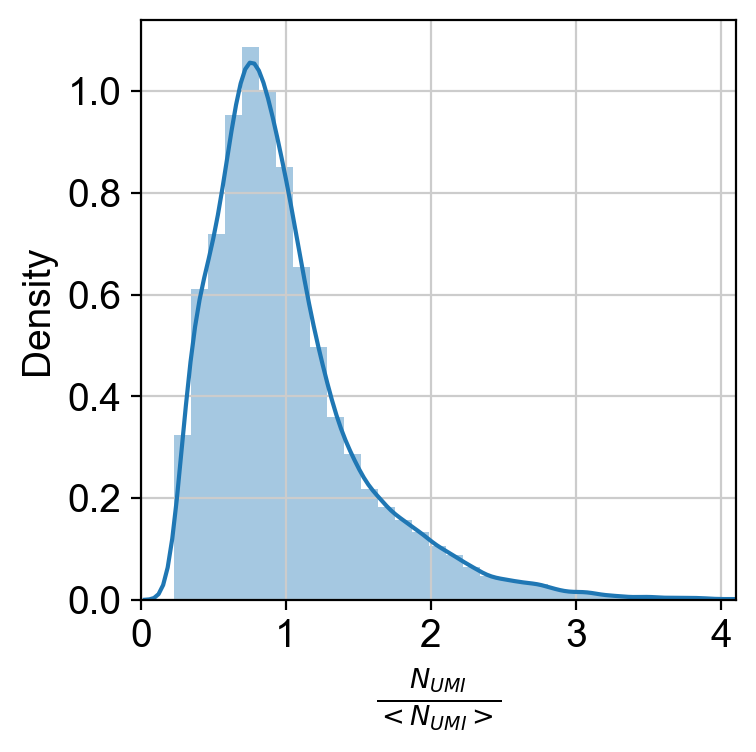

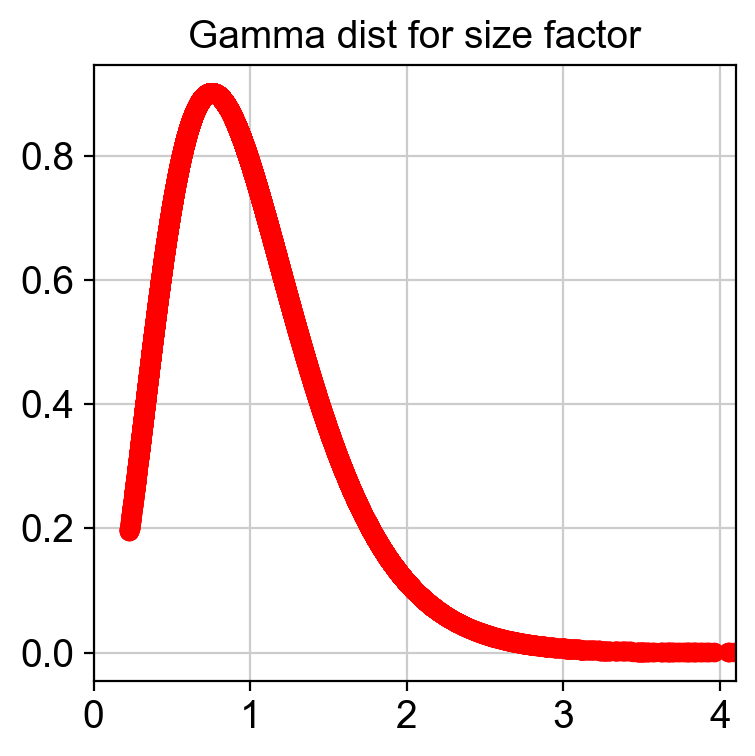

shape = 4.06
rate = 4.06


/Users/salwanbutrus/Desktop/Desktop_Organized/GoogleDrive/5-UCBPhD/Research/MIMB_chapter/iGraphBoost.py:191: RuntimeWarning: divide by zero encountered in true_divide
  b_i = (1/fit_scale)/mean_emp
/Users/salwanbutrus/Desktop/Desktop_Organized/GoogleDrive/5-UCBPhD/Research/MIMB_chapter/iGraphBoost.py:193: RuntimeWarning: invalid value encountered in true_divide
  var_NB = a_i*(1+b_i)/(b_i**2)
/Users/salwanbutrus/Desktop/Desktop_Organized/GoogleDrive/5-UCBPhD/Research/MIMB_chapter/iGraphBoost.py:194: RuntimeWarning: divide by zero encountered in true_divide
  cv_NB = np.sqrt(var_NB)/mean_NB
/Users/salwanbutrus/Desktop/Desktop_Organized/GoogleDrive/5-UCBPhD/Research/MIMB_chapter/iGraphBoost.py:197: RuntimeWarning: invalid value encountered in greater
  pass_cutoff = [i for i in list(adata.var.index[np.where(diffCV > diffCV_cutoff, True, False)]) if i in list(adata.var.index[np.where((mean_emp > 0.001) & (mean_emp < 5), True, False)])]
/Users/salwanbutrus/Desktop/Desktop_Organized/GoogleD

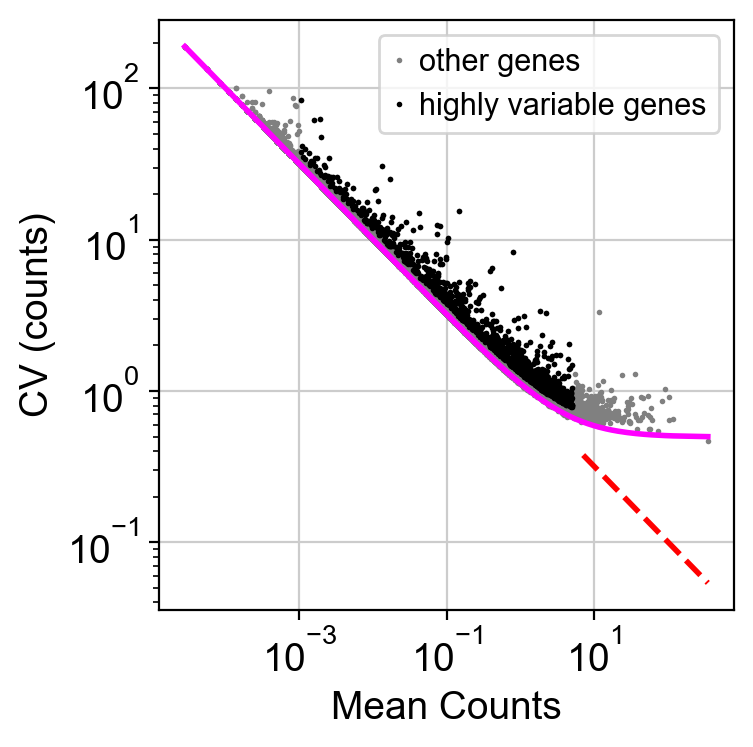

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    with n_comps=50
    finished (0:00:09)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).
computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda3/

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)


In [5]:
#identify HVGs
adata.var['highly_variable'] = meanCVfit(adata)

#z-scoring and PCA
adata.raw = adata #store unscaled data for plotting
sc.pp.scale(adata, max_value=10) #scale
sc.tl.pca(adata, svd_solver='arpack') #run PCA

#batch correction using Harmony and visualization using UMAP
Z = harmonize(adata.obsm['X_pca'], adata.obs, batch_key = 'Batch')
adata.obsm['X_harmony'] = Z
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_harmony')
sc.tl.umap(adata)


## Figure 1A, B

In [6]:
types_num = []
for i in range(adata.shape[0]):
    types_num.append(adata.obs.Type[i][0:3])
    
adata.obs['Type_num'] = adata.obs['Type']
adata.obs['Type_num'] = pd.Categorical(types_num)
adata.obs['Type_num'] = adata.obs['Type_num'].str.replace('_', '')
adata.obs['Type_num'] = pd.Categorical(list(adata.obs.Type_num.values))

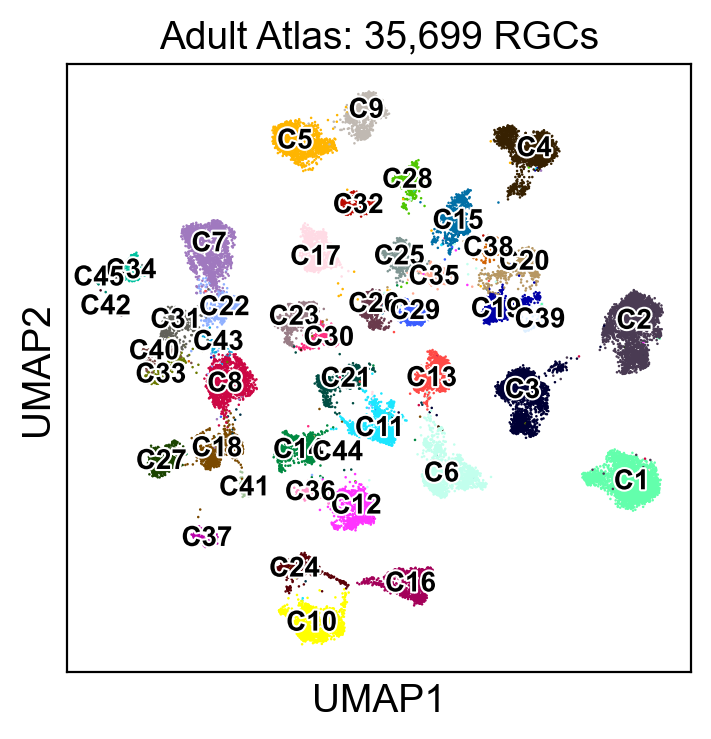

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.


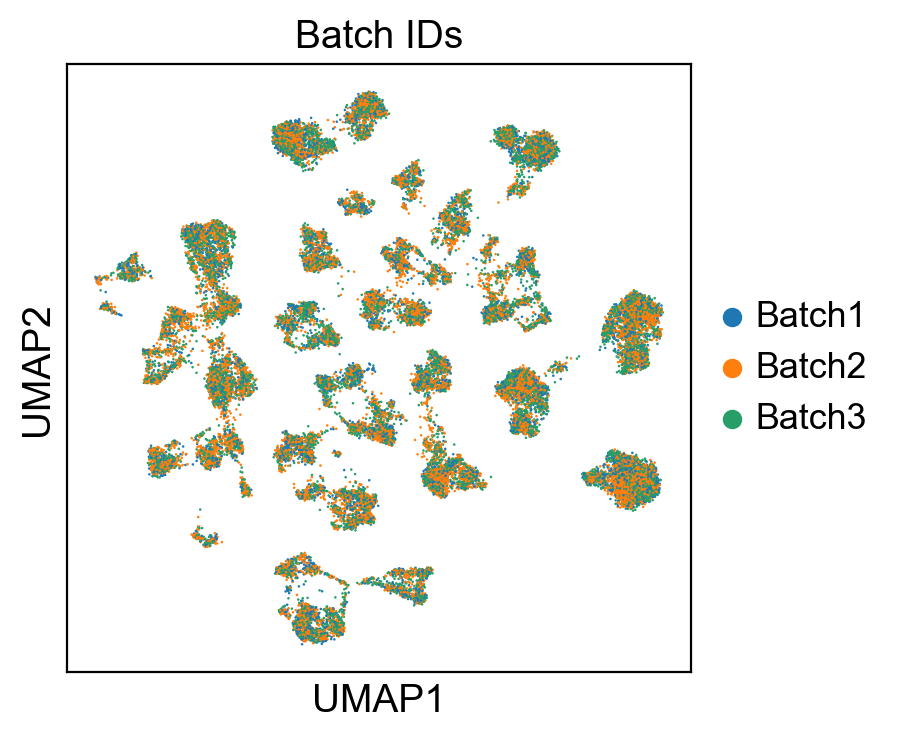

In [8]:
sc.pl.umap(adata, color=['Type_num'], legend_loc='on data',  
           title='Adult Atlas: 35,699 RGCs', legend_fontoutline=1.5, legend_fontsize=10)
sc.pl.umap(shuffle(adata), color= ['Batch'], title='Batch IDs')

In [100]:
#adata.write_h5ad('path/to/RGCatlas.h5ad')

## Figure 1C

In [10]:
adata_comb = diag_dotplot(adata)

In [66]:
cats = []
for i in range(1,46):
    cats.append('C' + str(i))

comb_vars = ['Serpine2+Amigo2+', 'Lypd1+Ntrk1-', 'Foxp2+Irx4+','Pde1a', 'Tbr1+Pcdh20+', 'Zic1', 'Tbx20+Tagln2+',
                'Prkcq+Tac1+Spp1-', 'Slc7a11+Plpp4+', 'Gpr88', 'Serpinb1b+Gm17750+', 'Mmp17', 'Lypd1+Ntrk1+', 'Cartpt+Vit+', 'Apela',
                'Cartpt+Col25a1+', 'Tbr1+Irx4+', 'Pcdh20+4833423E24Rik+', 'Penk+Prdm8+Slc24a2+',
                 'Penk+Gal+', 'Tbr1+Calca+', 'Serpine2+Cdhr1+', 'Prokr1', 'Fam19a4',
                'Slc17a7', 'Penk+Igfbp5+', 'Prkcg', 'Foxp2+Cdk15+', 'Stxbp6+Prlr+', 'Postn', 
                'Tbx20+Spp1+', 'Rhox5', 'Adcyap1+Opn4+Nmb-', 'Tpbg+Spp1-', 'Igfbp4+Chrm2+', 'Stxbp6+Coch+',
                'Ceacam10', 'Foxp2+Anxa3+', 'Neurod2+S100b+',  'Nmb', 'Spp1+Kit+', 'Spp1+Fes+',
                'Spp1+Il1rapl2+', 'Bhlhe22+Fxyd6+', 'Spp1+Tpbg+', ]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


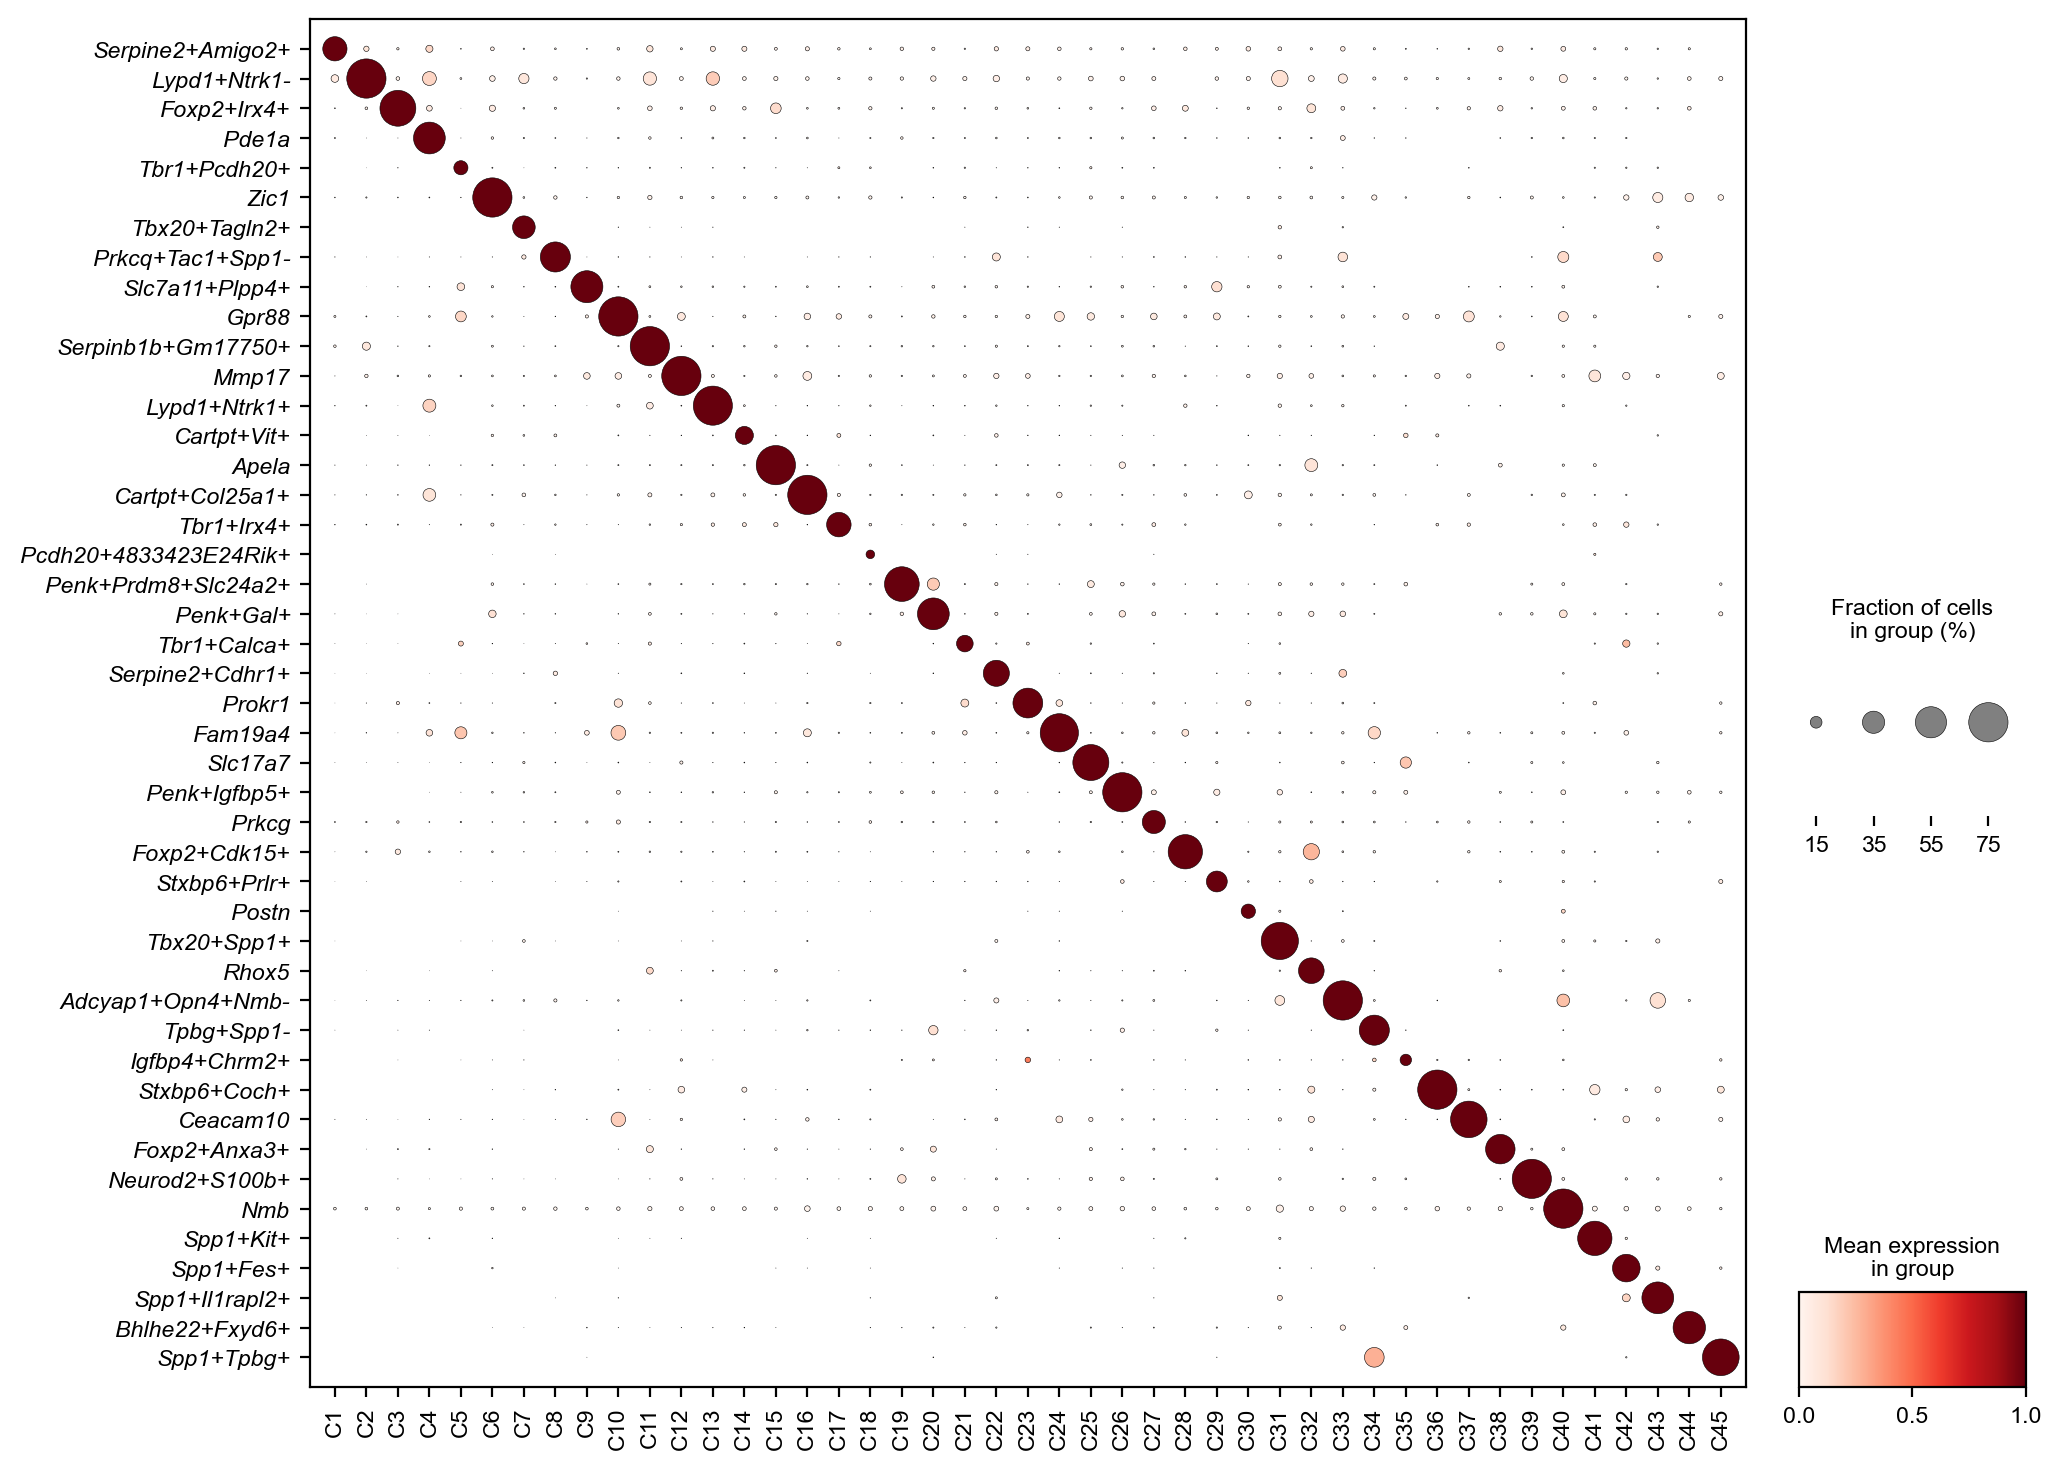

In [67]:
sc.set_figure_params(dpi=100, dpi_save = 200, fontsize=10)

fig, axs = plt.subplots(figsize=(11,9))

a = sc.pl.dotplot(adata_comb, var_names=comb_vars, groupby='Type_num', 
                  standard_scale='var', swap_axes=True, dot_min=0, dot_max=0.75, 
              figsize=(11,9),show=False, ax=axs, categories_order=cats)
a['mainplot_ax'].set_yticklabels(labels=comb_vars,fontstyle='italic')

#fig.savefig('Figure1C.pdf')

# 3.2 Read in injured RGCs as AnnData objects

In [102]:
onc_path = 'path/to/onc_data/'
adata = sc.read_mtx(onc_path+'onc.mtx')
adata_raw = sc.read_mtx(onc_path+'onc_raw.mtx')

In [103]:
adata.layers['raw'] = adata_raw.X
adata.var_names = pd.read_csv(onc_path + 'onc_vars.csv')['x'].values
adata.obs_names = pd.read_csv(onc_path + 'onc_obs.csv')['x'].values

adata.obs['Type'] = pd.Series(pd.read_csv(onc_path + 'onc_type.csv')['x'].values, dtype='category').values
adata.obs['Time'] = pd.Series(pd.read_csv(onc_path + 'onc_time.csv')['x'].values, dtype='category').values

**Pre-step1 for all ONC time points**

* Organize batch IDs. 
* Run each time point through `pre_step1()`

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


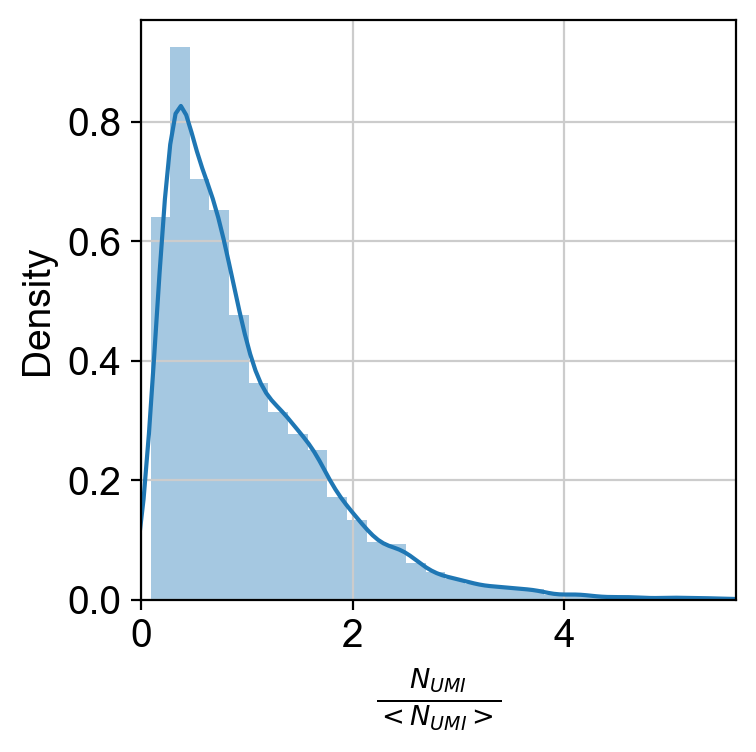

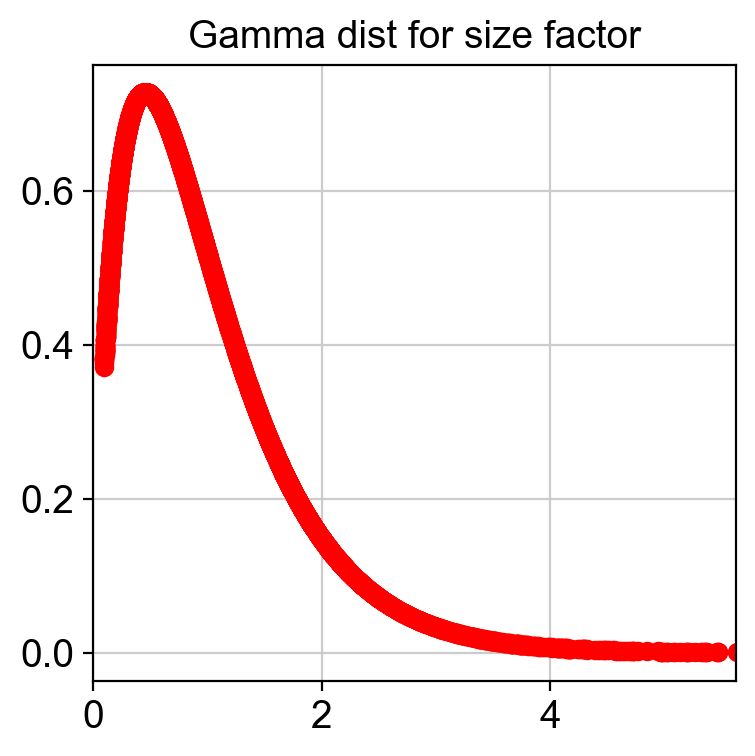

shape = 1.83
rate = 1.83


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide


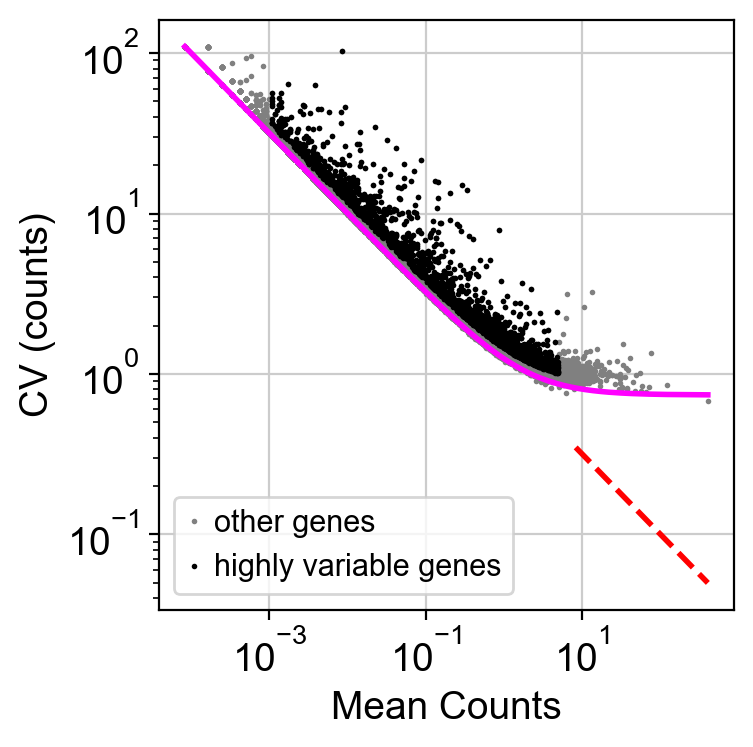

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:02)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).
computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [110]:
#ctrl
ctrl = adata[adata.obs.Time=='Ctrl',:]

ctrl_batch = []
for i in range(ctrl.shape[0]):
    item = ctrl.obs.index[i].split('_')[0]
    
    if (item in ['CtC57CD45CD90P1', 'CtC57CD45CD90P2', 'CtC57CD45CD90R1']):
        ctrl_batch.append('CtC57CD45CD90')
    else: ctrl_batch.append(item)

ctrl.obs['Batch'] = pd.Categorical(ctrl_batch).rename_categories(['Batch1', 'Batch2', 'Batch3', 'Batch4'])

ctrl = pre_step1(ctrl)

ctrl.write_h5ad('path/to/CtrlONC.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


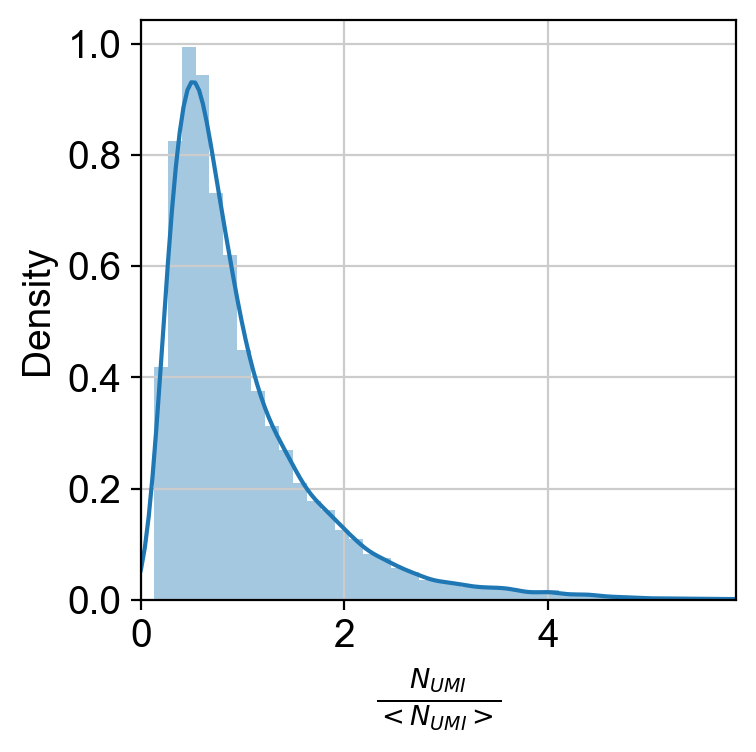

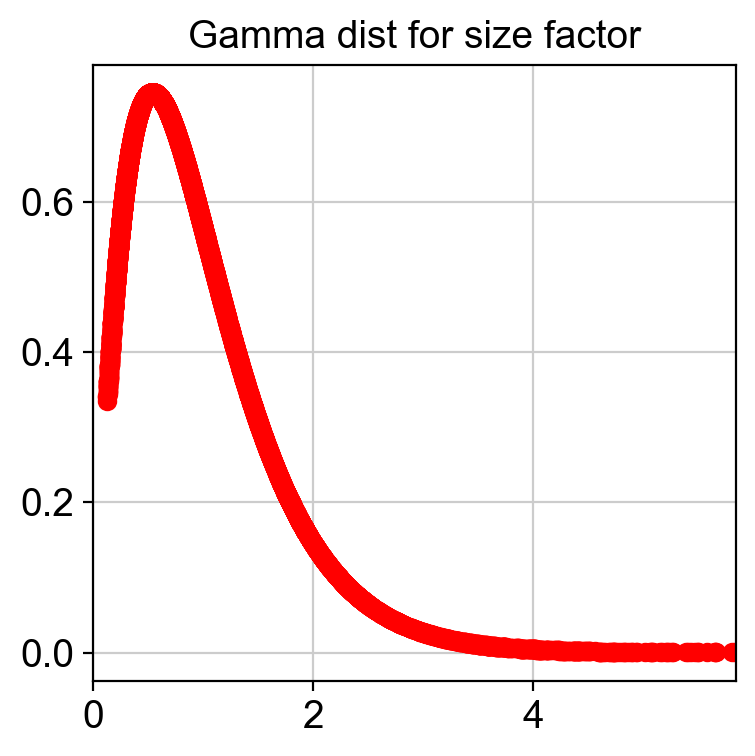

shape = 2.16
rate = 2.16


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide


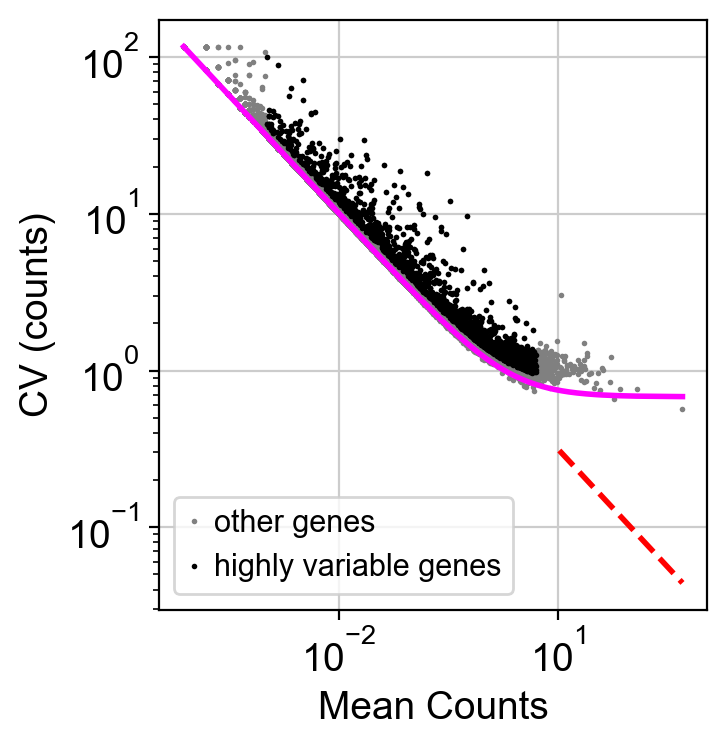

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:02)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).
computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [113]:
#12h
twelveHr = adata[adata.obs.Time=='12h',:]

twelveHr_batch = []
for i in range(twelveHr.shape[0]):
    item = twelveHr.obs.index[i].split('_')[0]
    twelveHr_batch.append(item)

twelveHr.obs['Batch'] = pd.Categorical(twelveHr_batch).rename_categories(['Batch1', 'Batch2', 'Batch3', 'Batch4'])

twelveHr = pre_step1(twelveHr)

twelveHr.write_h5ad('path/to/twelve_hrONC.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


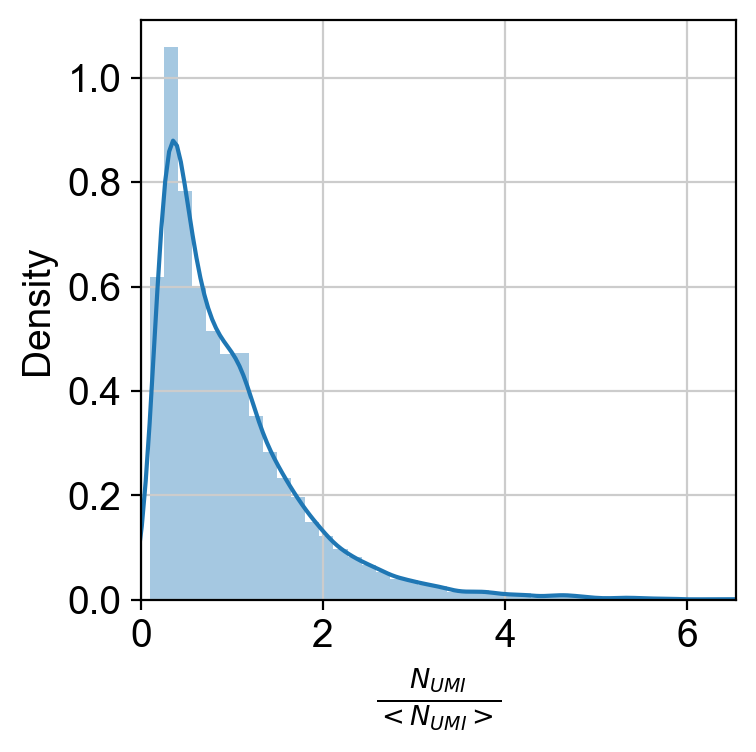

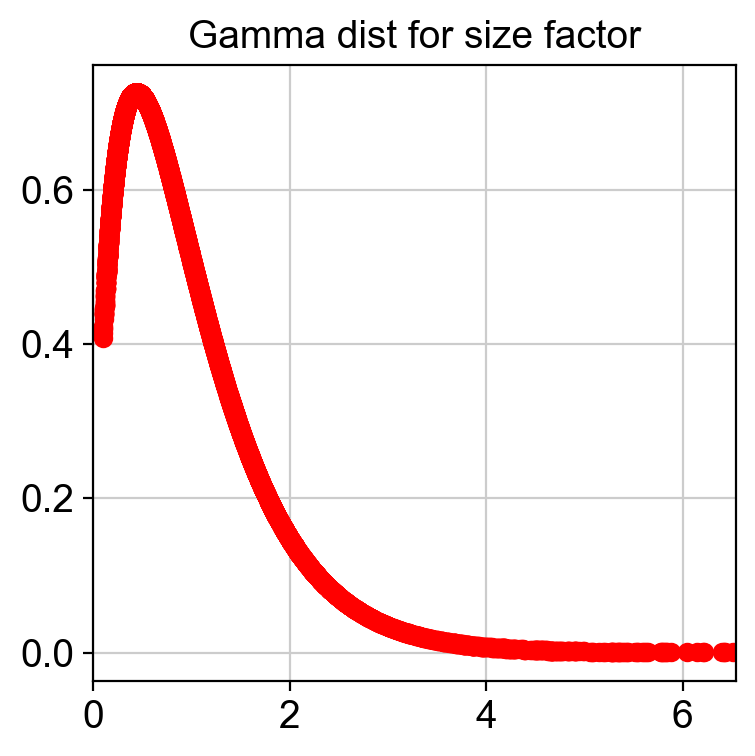

shape = 1.78
rate = 1.78


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide


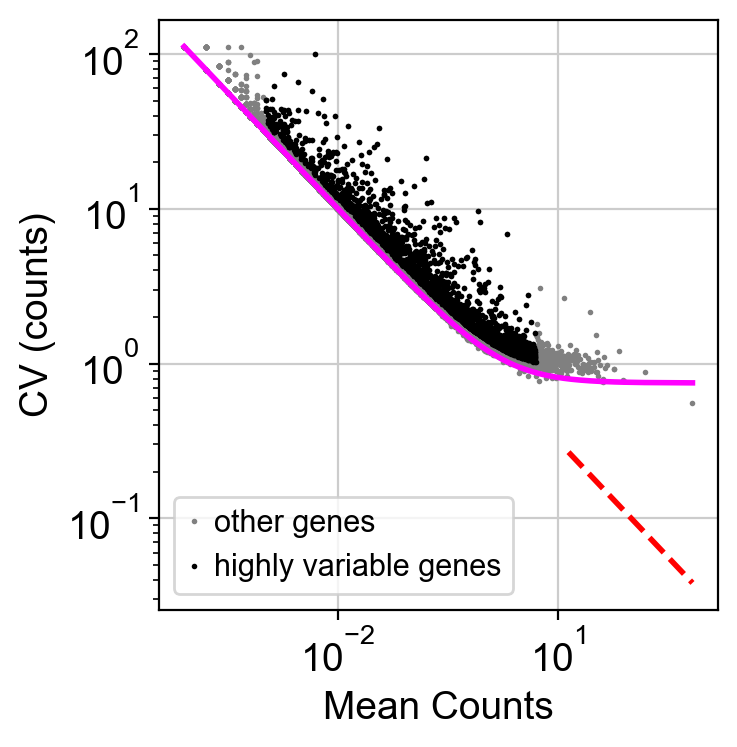

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:02)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).
computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [114]:
#1d
oneday = adata[adata.obs.Time=='1d',:]

oneday_batch = []
for i in range(oneday.shape[0]):
    item = oneday.obs.index[i].split('_')[0]
    oneday_batch.append(item)

oneday.obs['Batch'] = pd.Categorical(oneday_batch).rename_categories(['Batch1', 'Batch2', 'Batch3', 'Batch4', 'Batch5'])

oneday = pre_step1(oneday)

oneday.write_h5ad('path/to/onedayONC.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


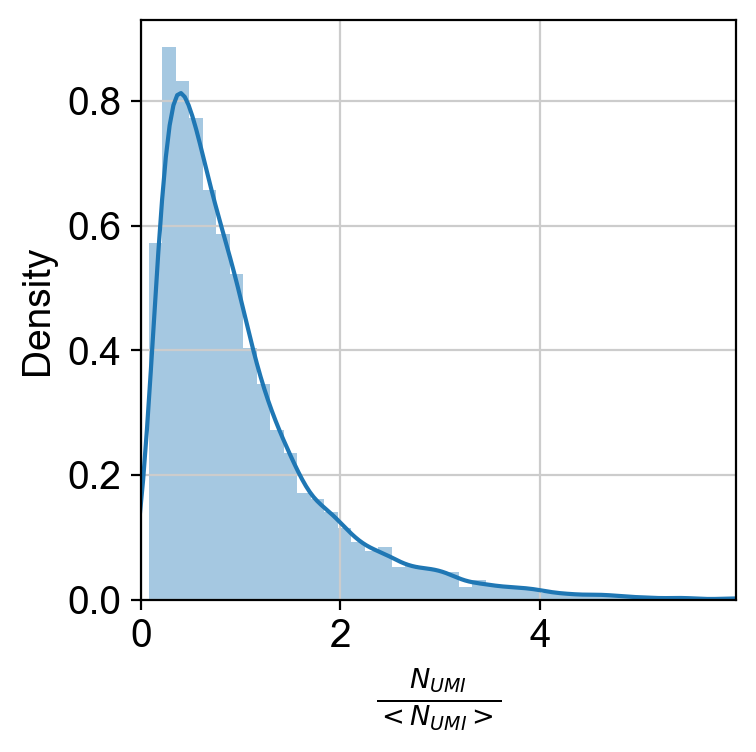

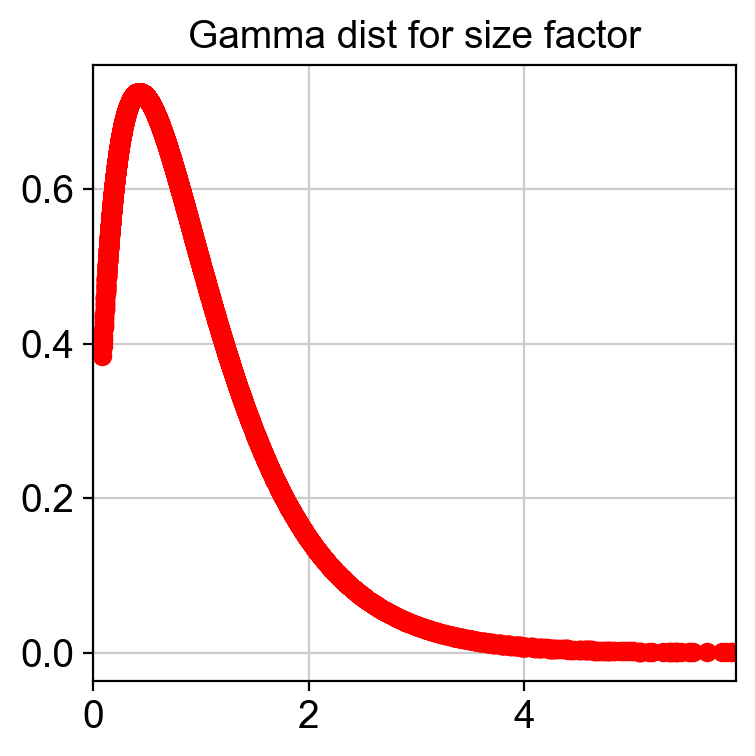

shape = 1.74
rate = 1.74


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide


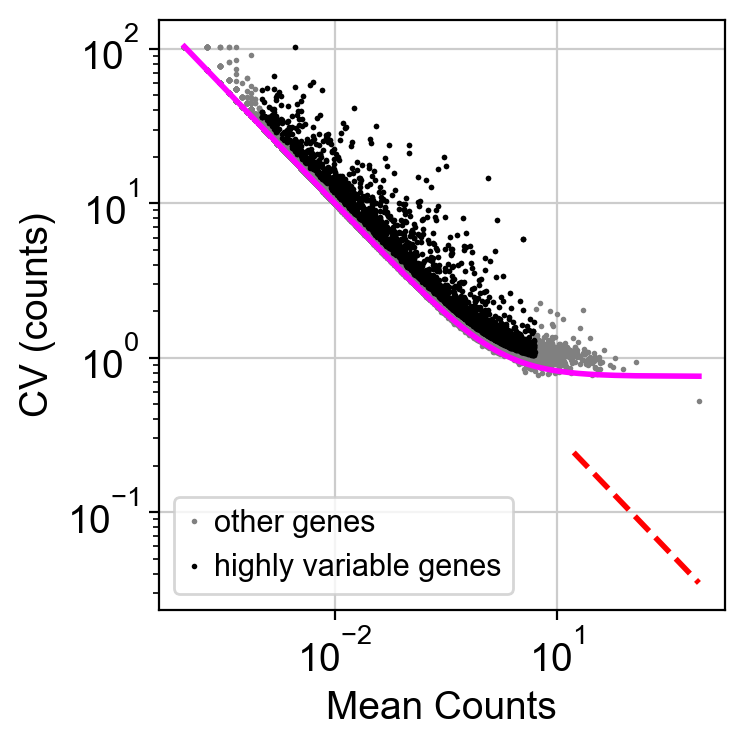

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    with n_comps=50
    finished (0:00:03)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).
computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [115]:
#2d
twoday = adata[adata.obs.Time=='2d',:]

twoday_batch = []
for i in range(twoday.shape[0]):
    item = twoday.obs.index[i].split('_')[0]
    twoday_batch.append(item)

twoday.obs['Batch'] = pd.Categorical(twoday_batch).rename_categories(['Batch1', 'Batch2', 'Batch3', 'Batch4', 'Batch5'])

twoday = pre_step1(twoday)

twoday.write_h5ad('path/to/twodayONC.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


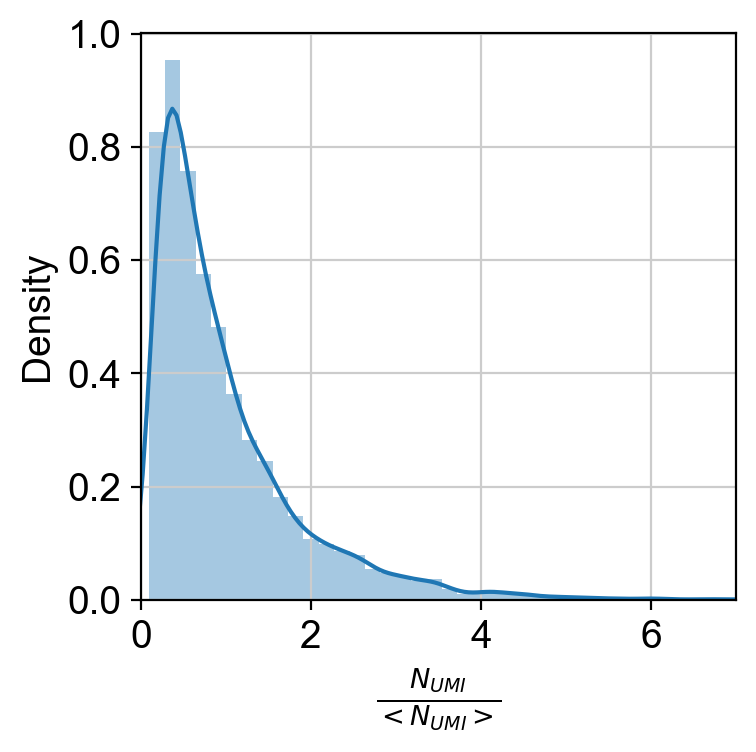

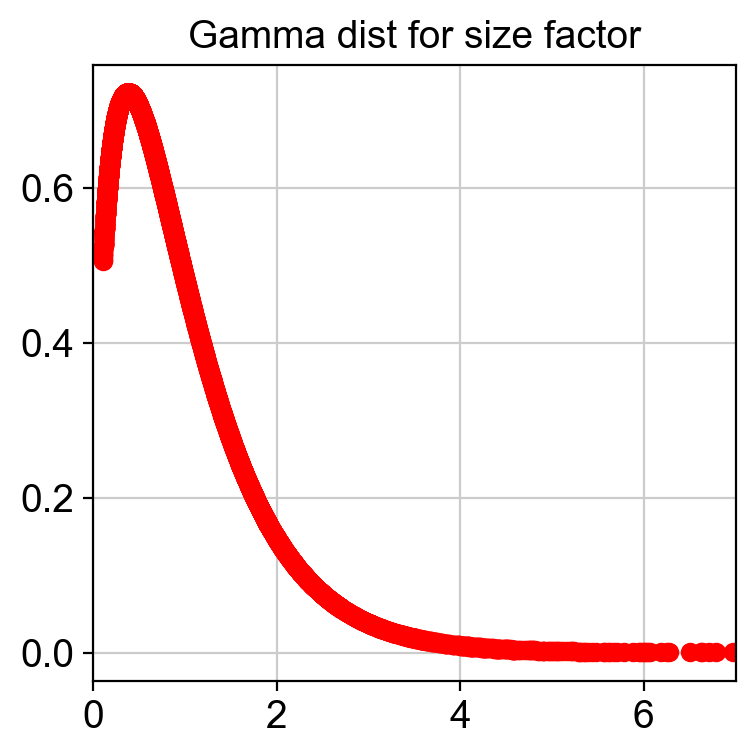

shape = 1.61
rate = 1.61


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide


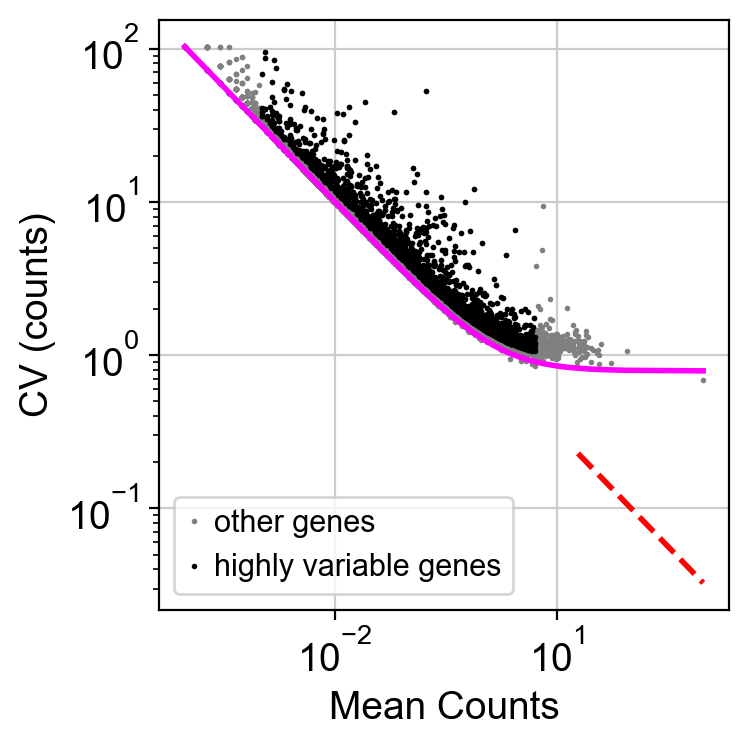

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    with n_comps=50
    finished (0:00:02)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).
computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [116]:
#4d
fourday = adata[adata.obs.Time=='4d',:]

fourday_batch = []
for i in range(fourday.shape[0]):
    item = fourday.obs.index[i].split('_')[0]
    fourday_batch.append(item)

fourday.obs['Batch'] = pd.Categorical(fourday_batch).rename_categories(['Batch1', 'Batch2', 'Batch3', 'Batch4'])

fourday = pre_step1(fourday)

fourday.write_h5ad('path/to/fourdayONC.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


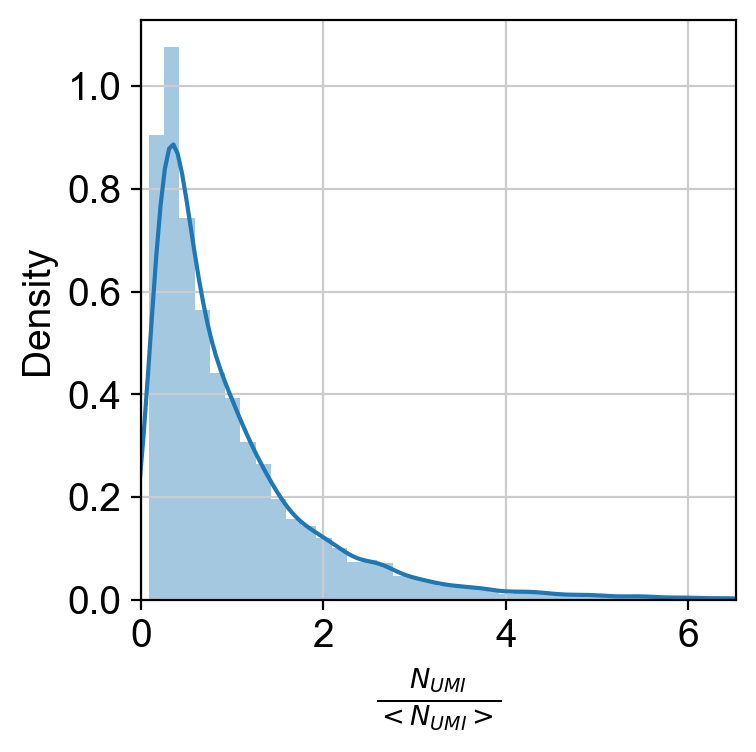

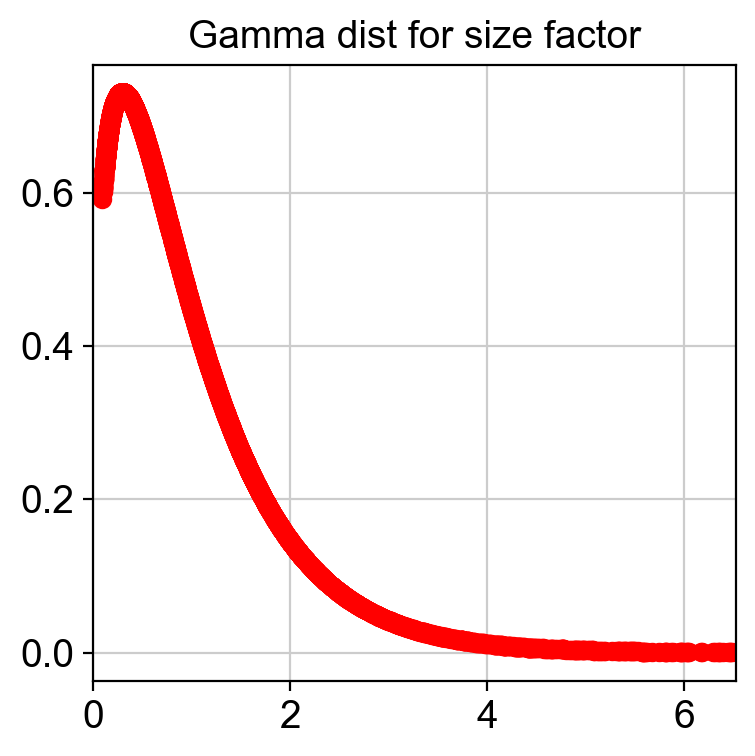

shape = 1.42
rate = 1.42


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide


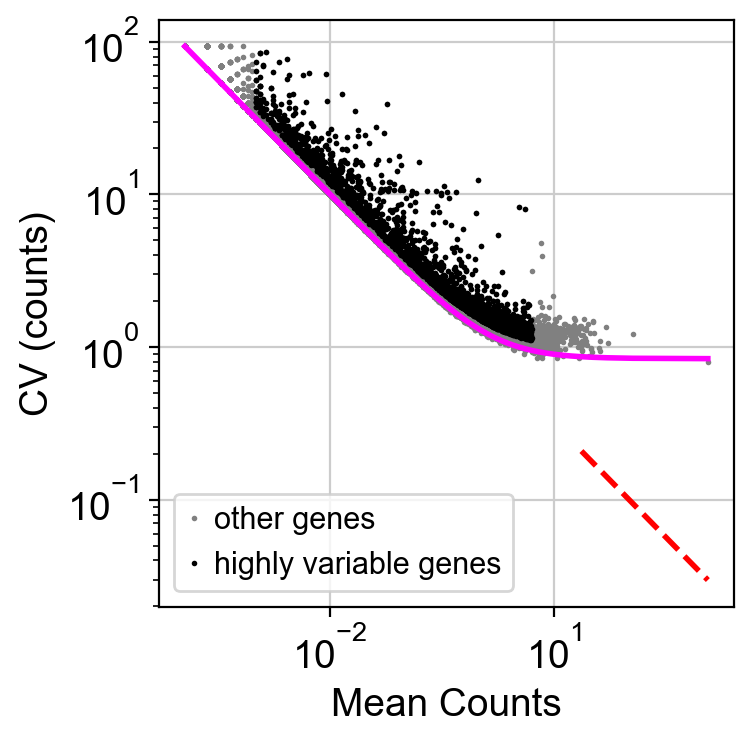

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    with n_comps=50
    finished (0:00:03)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).
computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


In [117]:
#1w
oneweek = adata[adata.obs.Time=='1w',:]

oneweek_batch = []
for i in range(oneweek.shape[0]):
    item = oneweek.obs.index[i].split('_')[0]
    oneweek_batch.append(item)

oneweek.obs['Batch'] = pd.Categorical(oneweek_batch).rename_categories(['Batch1', 'Batch2', 'Batch3', 'Batch4'])

oneweek = pre_step1(oneweek)

oneweek.write_h5ad('path/to/oneweekONC.h5ad')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


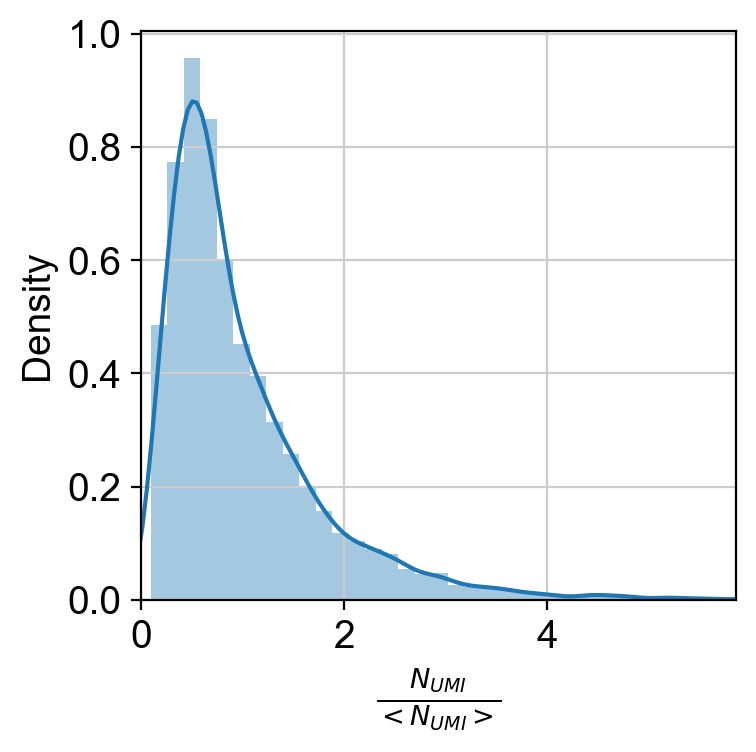

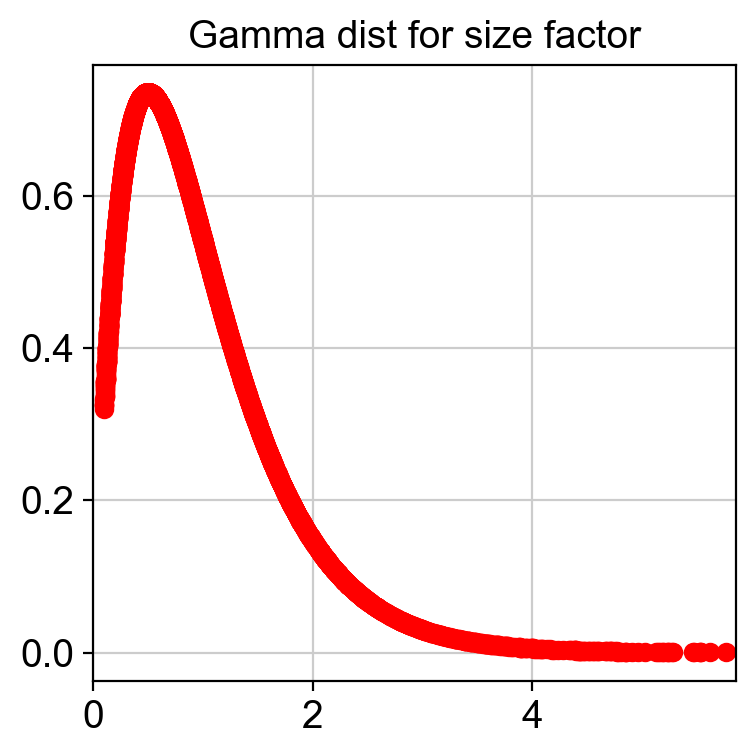

shape = 1.99
rate = 1.99


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide


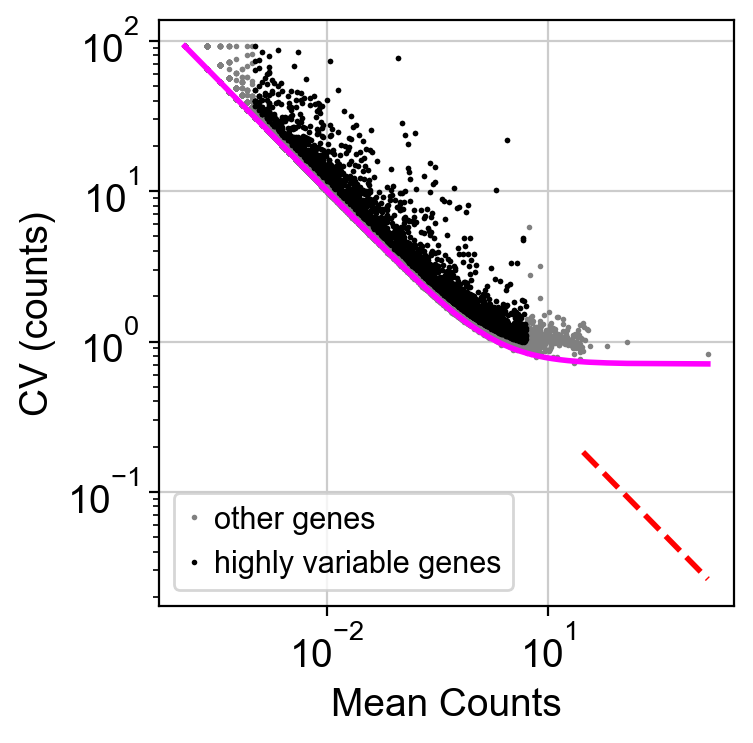

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:03)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


In [118]:
#2w
twoweek = adata[adata.obs.Time=='2w',:]

twoweek_batch = []
for i in range(twoweek.shape[0]):
    item = twoweek.obs.index[i].split('_')[0]
    twoweek_batch.append(item)

twoweek.obs['Batch'] = pd.Categorical(twoweek_batch).rename_categories(['Batch1', 'Batch2', 'Batch3', 'Batch4'])

twoweek = pre_step1(twoweek)

twoweek.write_h5ad('path/to/twoweekONC.h5ad')

# 3.3 iGraphBoost overview and classification of 0dpc RGCs 

Step 1

In [290]:
atlas = sc.read_h5ad('path/to/RGCatlas.h5ad')

atlas_genes = ClusterSpecificGenes(atlas,
                                   genes = list(atlas.var.index[atlas.var.highly_variable == True]),
                                   obs = 'Type_num')

var_genes = [i for i in atlas_genes if i in list(ctrl.var.index)]

In [ ]:
validation_label_train_10, valid_predlabels_train_10, test_predlabels = xgbtrainatlas(
    train_anndata = atlas,
    test_anndata = ctrl,
    genes = var_genes
    )

In [ ]:
validationconfmat, validationxticks, validationplot = plotValidationConfusionMatrix(
    ytrue = validation_label_train_10,
    ypred = valid_predlabels_train_10,
    save_as = 'Atlas_Validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

In [ ]:
mapping_assignments = []
for i in test_predlabels:
    if i == 45:
        mapping_assignments.append('Unassigned')
    else:
        mapping_assignments.append(str(int(i)+1))

ctrl.obs['Type_iGB'] = mapping_assignments

In [ ]:
ctrl.write_h5ad('path/to/CtrlONC_mapped.h5ad')

Step 2

In [ ]:
ctrl = nn_voting(ctrl)
ctrl.write_h5ad('path/to/CtrlONC_mapped_iGB.h5ad')

## Figure 2 C, D

In [68]:
ctrl = sc.read_h5ad('path/to/CtrlONC_mapped_iGB.h5ad')

adata = sc.read_h5ad('path/to/RGCatlas.h5ad')

In [75]:
ctrl = ctrl[ctrl.obs.Type_iGB!='Unassigned',:]

In [33]:
atlasclustnames = []
for i in adata.obs.Type.values.categories:
    atlasclustnames.append(i.split('_')[0].split('C')[1])

adata.obs['Type_nums'] = adata.obs.Type.cat.rename_categories(atlasclustnames)

In [34]:
ctrl_freqs = ctrl.obs.Type_iGB.value_counts(normalize=True)
atlas_freqs = adata.obs.Type_nums.value_counts(normalize=True)

ctrl_v_atlas = [[], []]

for i in adata.obs.Type_nums.values.categories:
    ctrl_v_atlas[0].append(ctrl_freqs[ctrl_freqs.index.get_loc(i)])
    ctrl_v_atlas[1].append(atlas_freqs[atlas_freqs.index.get_loc(i)])

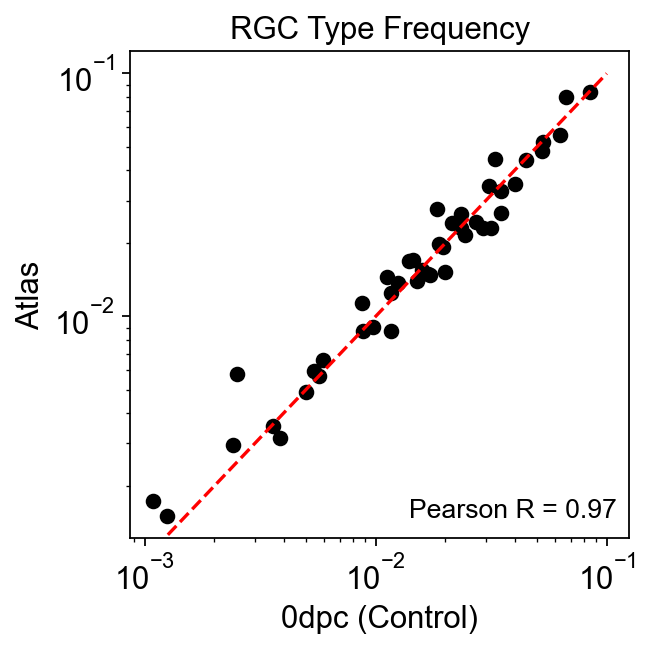

In [41]:
sc.set_figure_params(dpi_save=200, fontsize=14)
plt.scatter(ctrl_v_atlas[0], ctrl_v_atlas[1], color='black')
plt.plot(np.linspace(0,0.1), np.linspace(0,0.1), ls='--', color='red')
plt.title('RGC Type Frequency')
plt.grid(False)
plt.xlabel('0dpc (Control)')
plt.ylabel('Atlas')
plt.text(0.014,0.0015, r'Pearson R = ' + str(np.round(sp.stats.pearsonr(ctrl_v_atlas[0], ctrl_v_atlas[1])[0], 2)), 
         {'color': 'black', 'fontsize': 12})

plt.yscale('log')
plt.xscale('log')
plt.savefig('Figure2C.pdf')
plt.show()

Reorder types for dot plot.

In [69]:
iGB_C = []
for i in ctrl.obs.Type_iGB.values:
    iGB_C.append('C'+str(i))
    
ctrl.obs['Type_iGB_C'] = pd.Categorical(iGB_C)   

In [84]:
ctrl_comb = diag_dotplot(ctrl)

In [85]:
cats = []
for i in range(1,46):
    cats.append('C' + str(i))

comb_vars = ['Serpine2+Amigo2+', 'Lypd1+Ntrk1-', 'Foxp2+Irx4+','Pde1a', 'Tbr1+Pcdh20+', 'Zic1', 'Tbx20+Tagln2+',
                'Prkcq+Tac1+Spp1-', 'Slc7a11+Plpp4+', 'Gpr88', 'Serpinb1b+Gm17750+', 'Mmp17', 'Lypd1+Ntrk1+', 'Cartpt+Vit+', 'Apela',
                'Cartpt+Col25a1+', 'Tbr1+Irx4+', 'Pcdh20+4833423E24Rik+', 'Penk+Prdm8+Slc24a2+',
                 'Penk+Gal+', 'Tbr1+Calca+', 'Serpine2+Cdhr1+', 'Prokr1', 'Fam19a4',
                'Slc17a7', 'Penk+Igfbp5+', 'Prkcg', 'Foxp2+Cdk15+', 'Stxbp6+Prlr+', 'Postn', 
                'Tbx20+Spp1+', 'Rhox5', 'Adcyap1+Opn4+Nmb-', 'Tpbg+Spp1-', 'Igfbp4+Chrm2+', 'Stxbp6+Coch+',
                'Ceacam10', 'Foxp2+Anxa3+', 'Neurod2+S100b+',  'Nmb', 'Spp1+Kit+', 'Spp1+Fes+',
                'Spp1+Il1rapl2+', 'Bhlhe22+Fxyd6+', 'Spp1+Tpbg+', ]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


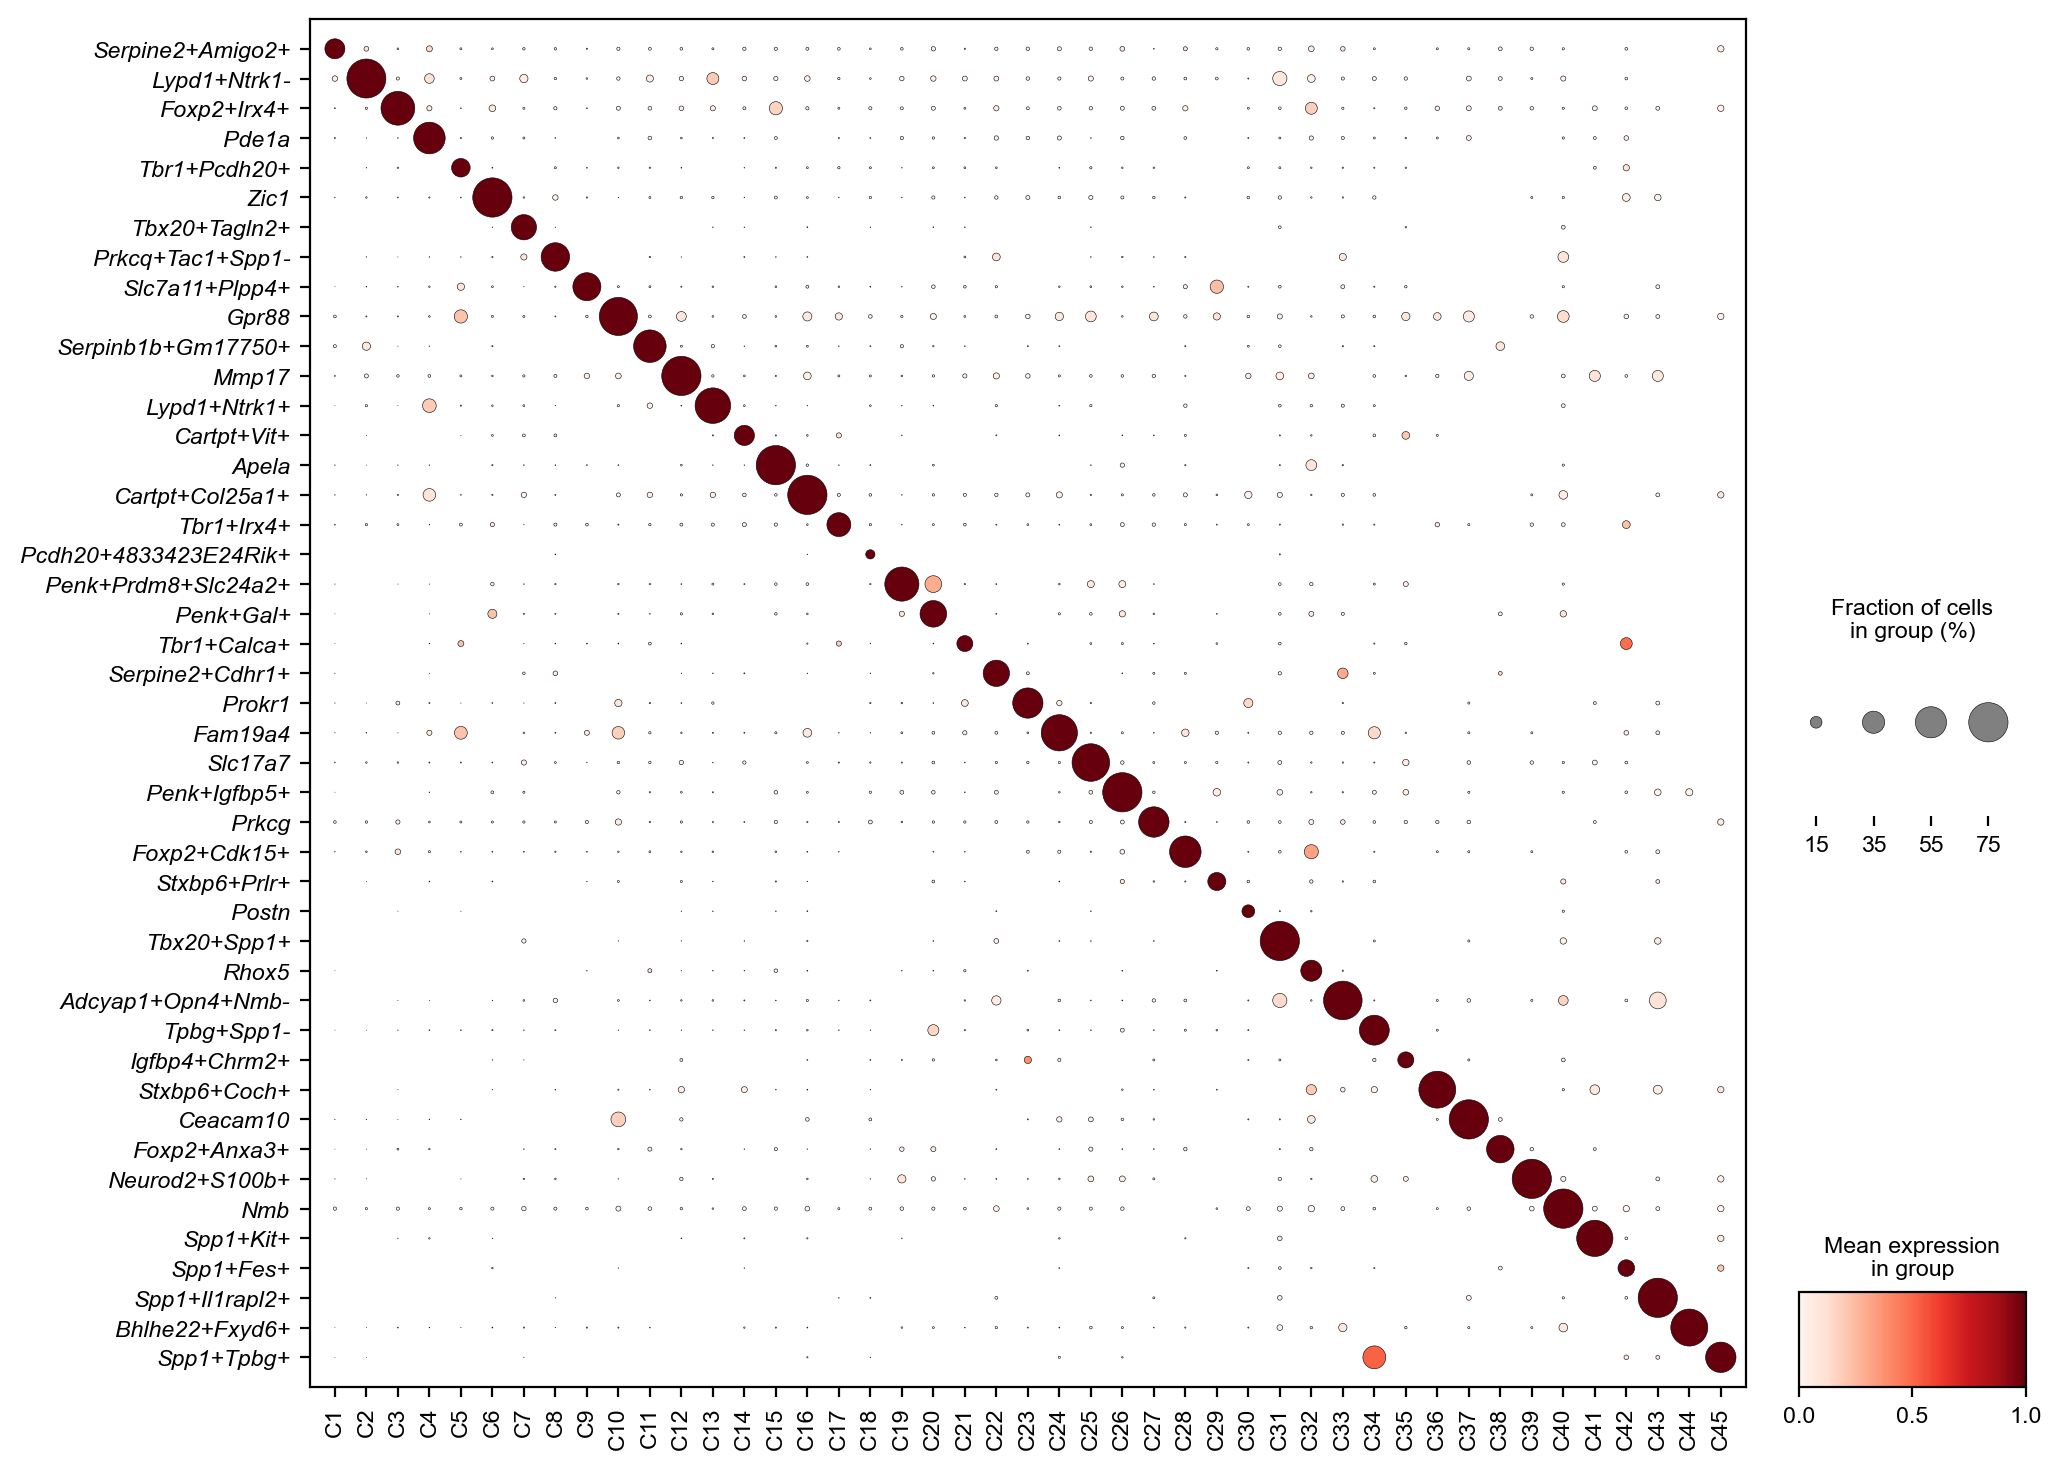

In [86]:
sc.set_figure_params(dpi=100, dpi_save = 200, fontsize=10)



fig, axs = plt.subplots(figsize=(11,9))

a = sc.pl.dotplot(ctrl_comb, var_names=comb_vars, groupby='Type_iGB_C', 
                  standard_scale='var', swap_axes=True, dot_min=0, dot_max=0.75, 
              figsize=(11,9),show=False, ax=axs, categories_order=cats)
a['mainplot_ax'].set_yticklabels(labels=comb_vars,fontstyle='italic')

fig.savefig('Figure2D.pdf')

# 3.4 iGraphBoost classification of 0.5dpc, 1dpc and 2dpc RGCs

## iGB: 12h vs ctrl

Step 1

In [ ]:
ctrl_genes = ClusterSpecificGenes(ctrl,
                                  genes = list(ctrl.var.index[ctrl.var.highly_variable == True]),
                                  obs = 'Type_iGB')

all_var_genes = [i for i in ctrl_genes if i in list(twelveHr.var.index)]

exclude_genes_df = pd.read_csv('path/to/TemporalMarkersONC.txt', header = None, names = ['Genes'])
exclude_genes = list(exclude_genes_df['Genes'])

var_genes = []
for i in all_var_genes:
    if i not in exclude_genes:
        var_genes.append(i)

In [ ]:
#train ctrl classifier only on assigned ctrl cells
assigned_cells = []
for i in range(len(ctrl.obs)):
    if ctrl.obs.Type_iGB[i] != 'Unassigned':
        assigned_cells.append(ctrl.obs.index[i])

In [ ]:
validation_label_train_10, valid_predlabels_train_10, test_predlabels = xgbtrain(
    train_anndata = ctrl[assigned_cells,:],
    test_anndata = twelveHr,
    genes = var_genes
    )

In [ ]:
validationconfmat, validationxticks, validationplot = plotValidationConfusionMatrix(
    ytrue = validation_label_train_10,
    ypred = valid_predlabels_train_10,
    save_as = 'Ctrl_Validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

In [ ]:
mapping_assignments = []
unassigned_index = []
for index, value in enumerate(test_predlabels):
    if value == 45:
        mapping_assignments.append('Unassigned')
        unassigned_index.append(index)
    else:
        mapping_assignments.append(str(int(value)+1))

In [ ]:
twelveHr.obs['Type_iGB'] = mapping_assignments

Mapping unassigned cells at 12h to Atlas

In [ ]:
all_var_genes = [i for i in atlas_genes if i in list(twelveHr.var.index)]

var_genes = []
for i in all_var_genes:
    if i not in exclude_genes:
        var_genes.append(i)

In [ ]:
unassigned_cells = []
for i in range(len(twelveHr.obs)):
    if twelveHr.obs.Type_iGB[i] == 'Unassigned':
        unassigned_cells.append(twelveHr.obs.index[i])

In [ ]:
validation_label_train_10, valid_predlabels_train_10, test_predlabels = xgbtrainatlas(
    train_anndata = atlas,
    test_anndata = twelveHr[unassigned_cells,:],
    genes = var_genes
    )

In [ ]:
validationconfmat, validationxticks, validationplot = plotValidationConfusionMatrix(
    ytrue = validation_label_train_10,
    ypred = valid_predlabels_train_10,
    save_as = '',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

In [ ]:
unassigned_mapping_assignments = []
for i in test_predlabels:
    if i == 45:
        unassigned_mapping_assignments.append('Unassigned')
    else:
        unassigned_mapping_assignments.append(str(int(i)+1))

In [ ]:
for index, value in enumerate(unassigned_index):
    mapping_assignments[value] = unassigned_mapping_assignments[index]

In [ ]:
twelveHr.obs['Type_iGB'] = mapping_assignments

In [ ]:
twelveHr.write_h5ad('path/to/twelve_hrONC_mapped.h5ad')

Step 2

In [49]:
twelveHr = nn_voting(twelveHr)
twelveHr.write_h5ad('path/to/twelve_hrONC_mapped_iGB.h5ad')

## iGB: 1d vs 12h

Step 1

In [ ]:
twelvehr_genes = ClusterSpecificGenes(twelveHr,
                                      genes = list(twelveHr.var.index[twelveHr.var.highly_variable == True]),
                                      obs = 'Type_iGB')

all_var_genes = [i for i in twelvehr_genes if i in list(oneday.var.index)]

var_genes = []
for i in all_var_genes:
    if i not in exclude_genes:
        var_genes.append(i)

In [ ]:
assigned_cells = []
for i in range(len(twelveHr.obs)):
    if twelveHr.obs.Type_iGB[i] != 'Unassigned':
        assigned_cells.append(twelveHr.obs.index[i])

In [ ]:
validation_label_train_10, valid_predlabels_train_10, test_predlabels = xgbtrain(
    train_anndata = twelveHr[assigned_cells,:],
    test_anndata = oneday,
    genes = var_genes
    )

In [ ]:
validationconfmat, validationxticks, validationplot = plotValidationConfusionMatrix(
    ytrue = validation_label_train_10,
    ypred = valid_predlabels_train_10,
    save_as = 'TwelveHr_Validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

In [ ]:
mapping_assignments = []
unassigned_index = []
for index, value in enumerate(test_predlabels):
    if value == 45:
        mapping_assignments.append('Unassigned')
        unassigned_index.append(index)
    else:
        mapping_assignments.append(str(int(value)+1))

In [ ]:
oneday.obs['Type_iGB'] = mapping_assignments

Mapping Unassigned cells at 1d to Atlas

In [ ]:
all_var_genes = [i for i in atlas_genes if i in list(oneday.var.index)]

var_genes = []
for i in all_var_genes:
    if i not in exclude_genes:
        var_genes.append(i)

In [ ]:
unassigned_cells = []
for i in range(len(oneday.obs)):
    if oneday.obs.Type_iGB[i] == 'Unassigned':
        unassigned_cells.append(oneday.obs.index[i])

In [ ]:
validation_label_train_10, valid_predlabels_train_10, test_predlabels = xgbtrainatlas(
    train_anndata = atlas,
    test_anndata = oneday[unassigned_cells,:],
    genes = var_genes
    )

In [ ]:
validationconfmat, validationxticks, validationplot = plotValidationConfusionMatrix(
    ytrue = validation_label_train_10,
    ypred = valid_predlabels_train_10,
    save_as = '',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

In [ ]:
unassigned_mapping_assignments = []
for i in test_predlabels:
    if i == 45:
        unassigned_mapping_assignments.append('Unassigned')
    else:
        unassigned_mapping_assignments.append(str(int(i)+1))

In [ ]:
for index, value in enumerate(unassigned_index):
    mapping_assignments[value] = unassigned_mapping_assignments[index]

In [ ]:
oneday.obs['Type_iGB'] = mapping_assignments

In [ ]:
oneday.write_h5ad('path/to/onedayONC_mapped.h5ad')

Step 2

In [ ]:
oneday = nn_voting(oneday)
oneday.write_h5ad('path/to/onedayONC_mapped_iGB.h5ad')

## iGB: 2d vs 1d

Step 1

In [ ]:
oneday_genes = ClusterSpecificGenes(oneday,
                                    genes = list(oneday.var.index[oneday.var.highly_variable == True]),
                                    obs = 'Type_iGB')

all_var_genes = [i for i in oneday_genes if i in list(twoday.var.index)]

var_genes = []
for i in all_var_genes:
    if i not in exclude_genes:
        var_genes.append(i)

In [ ]:
assigned_cells = []
for i in range(len(oneday.obs)):
    if oneday.obs.Type_iGB[i] != 'Unassigned':
        assigned_cells.append(oneday.obs.index[i])

In [ ]:
validation_label_train_10, valid_predlabels_train_10, test_predlabels = xgbtrain(
    train_anndata = oneday[assigned_cells,:],
    test_anndata = twoday,
    genes = var_genes
    )

In [ ]:
validationconfmat, validationxticks, validationplot = plotValidationConfusionMatrix(
    ytrue = validation_label_train_10,
    ypred = valid_predlabels_train_10,
    save_as = '1d_Validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

In [ ]:
mapping_assignments = []
unassigned_index = []
for index, value in enumerate(test_predlabels):
    if value == 45:
        mapping_assignments.append('Unassigned')
        unassigned_index.append(index)
    else:
        mapping_assignments.append(str(int(value)+1))

In [ ]:
twoday.obs['Type_iGB'] = mapping_assignments

Mapping Unassigned cells at 2d to Atlas

In [ ]:
all_var_genes = [i for i in atlas_genes if i in list(twoday.var.index)]

var_genes = []
for i in all_var_genes:
    if i not in exclude_genes:
        var_genes.append(i)

In [ ]:
unassigned_cells = []
for i in range(len(twoday.obs)):
    if twoday.obs.Type_iGB[i] == 'Unassigned':
        unassigned_cells.append(twoday.obs.index[i])

In [ ]:
validation_label_train_10, valid_predlabels_train_10, test_predlabels = xgbtrainatlas(
    train_anndata = atlas,
    test_anndata = twoday[unassigned_cells,:],
    genes = var_genes
    )

In [ ]:
validationconfmat, validationxticks, validationplot = plotValidationConfusionMatrix(
    ytrue = validation_label_train_10,
    ypred = valid_predlabels_train_10,
    save_as = '',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

In [ ]:
unassigned_mapping_assignments = []
for i in test_predlabels:
    if i == 45:
        unassigned_mapping_assignments.append('Unassigned')
    else:
        unassigned_mapping_assignments.append(str(int(i)+1))

In [ ]:
for index, value in enumerate(unassigned_index):
    mapping_assignments[value] = unassigned_mapping_assignments[index]

In [ ]:
twoday.obs['Type_iGB'] = mapping_assignments

In [ ]:
twoday.write_h5ad('path/to/twodayONC_mapped.h5ad')

Step 2

In [103]:
twoday = nn_voting(twoday)
twoday.write_h5ad('path/to/twodayONC_mapped_iGB.h5ad')

# 3.5 iGraphBoost classification of 4d, 7d and 14d RGCs

Step 1

In [ ]:
rgc_early = twelveHr.concatenate(oneday, twoday)
rgc_late = fourday.concatenate(oneweek, twoweek)

In [ ]:
twoday_genes = ClusterSpecificGenes(twoday,
                                    genes = list(twoday.var.index[twoday.var.highly_variable == True]),
                                    obs = 'Type_iGB')

combined_var_genes = twelvehr_genes + oneday_genes + twoday_genes
var_genes_12h_1d_2d = list(np.unique(combined_var_genes))

all_var_genes = [i for i in var_genes_12h_1d_2d if i in list(rgc_late.var.index)]

var_genes = []
for i in all_var_genes:
    if i not in exclude_genes:
        var_genes.append(i)

In [ ]:
assigned_cells = []
for i in range(len(rgc_early.obs)):
    if rgc_early.obs.Type_iGB[i] != 'Unassigned':
        assigned_cells.append(rgc_early.obs.index[i])

In [ ]:
validation_label_train_10, valid_predlabels_train_10, test_predlabels = xgbtrain(
    train_anndata = rgc_early[assigned_cells,:],
    test_anndata = rgc_late,
    genes = var_genes
    )

In [ ]:
validationconfmat, validationxticks, validationplot = plotValidationConfusionMatrix(
    ytrue = validation_label_train_10,
    ypred = valid_predlabels_train_10,
    save_as = 'RGC_Early_Validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

In [ ]:
mapping_assignments = []
unassigned_index = []
for index, value in enumerate(test_predlabels):
    if value == 45:
        mapping_assignments.append('Unassigned')
        unassigned_index.append(index)
    else:
        mapping_assignments.append(str(int(value)+1))

In [ ]:
rgc_late.obs['Type_iGB'] = mapping_assignments

Mapping Unassigned cells in rgc_late to Atlas

In [ ]:
all_var_genes = [i for i in atlas_genes if i in list(rgc_late.var.index)]

var_genes = []
for i in all_var_genes:
    if i not in exclude_genes:
        var_genes.append(i)

In [ ]:
unassigned_cells = []
for i in range(len(rgc_late.obs)):
    if rgc_late.obs.Type_iGB[i] == 'Unassigned':
        unassigned_cells.append(rgc_late.obs.index[i])

In [ ]:
validation_label_train_10, valid_predlabels_train_10, test_predlabels = xgbtrainatlas(
    train_anndata = atlas,
    test_anndata = rgc_late[unassigned_cells,:],
    genes = var_genes
    )

In [ ]:
validationconfmat, validationxticks, validationplot = plotValidationConfusionMatrix(
    ytrue = validation_label_train_10,
    ypred = valid_predlabels_train_10,
    save_as = '',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

In [ ]:
unassigned_mapping_assignments = []
for i in test_predlabels:
    if i == 45:
        unassigned_mapping_assignments.append('Unassigned')
    else:
        unassigned_mapping_assignments.append(str(int(i)+1))

In [ ]:
for index, value in enumerate(unassigned_index):
    mapping_assignments[value] = unassigned_mapping_assignments[index]

In [ ]:
rgc_late.obs['Type_iGB'] = mapping_assignments

In [ ]:
rgc_late.write_h5ad('path/to/rgc_lateONC_mapped.h5ad')

Step 2

In [114]:
fourday = rgc_late[rgc_late.obs.Time=='4d',:]
fourday = nn_voting(fourday)

fourday.write_h5ad('path/to/fourdayONC_mapped_iGB.h5ad')

In [137]:
oneweek = rgc_late[rgc_late.obs.Time=='1w',:]
oneweek = nn_voting(oneweek)

oneweek.write_h5ad('path/to/oneweekONC_mapped_iGB.h5ad')

In [148]:
twoweek = rgc_late[rgc_late.obs.Time=='2w',:]
twoweek = nn_voting(twoweek)

twoweek.write_h5ad('path/to/twoweekONC_mapped_iGB.h5ad')

## Figure 4A: survival plot

In [18]:
twoweek = sc.read_h5ad('path/to/twoweekONC_mapped_iGB.h5ad')
ctrl = sc.read_h5ad('path/to/CtrlONC_mapped_iGB.h5ad')

In [19]:
ctrl = ctrl[ctrl.obs.Type_iGB!='Unassigned',:]
twoweek = twoweek[twoweek.obs.Type_iGB!='Unassigned',:]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [20]:
twoweek_freqs = twoweek.obs.Type_iGB.value_counts(normalize=True)
ctrl_freqs = ctrl.obs.Type_iGB.value_counts(normalize=True)

#clusts = ['43', '10', '33', '22', '42', '40', '31', '6', '7', '30', '27', 
#          '2', '39', '4', '32', '8', '5', '18', '19', '3', '16', '45', '12', '44', '41', '13', '24',
#         '9', '14', '38', '21', '34', '37', '17', '35', '20', '11', '1', '15', '36',
#         '29', '25', '23', '26', '28']
#len(clusts)

In [21]:
surv_scores = dict()
for i in twoweek.obs.Type_iGB.values.categories:
    surv_scores['C'+i] = (np.log2(twoweek_freqs[twoweek_freqs.index.get_loc(i)]/ctrl_freqs[ctrl_freqs.index.get_loc(i)]))

In [22]:
surv_scores_sorted = pd.Series(surv_scores).sort_values(ascending=False)

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


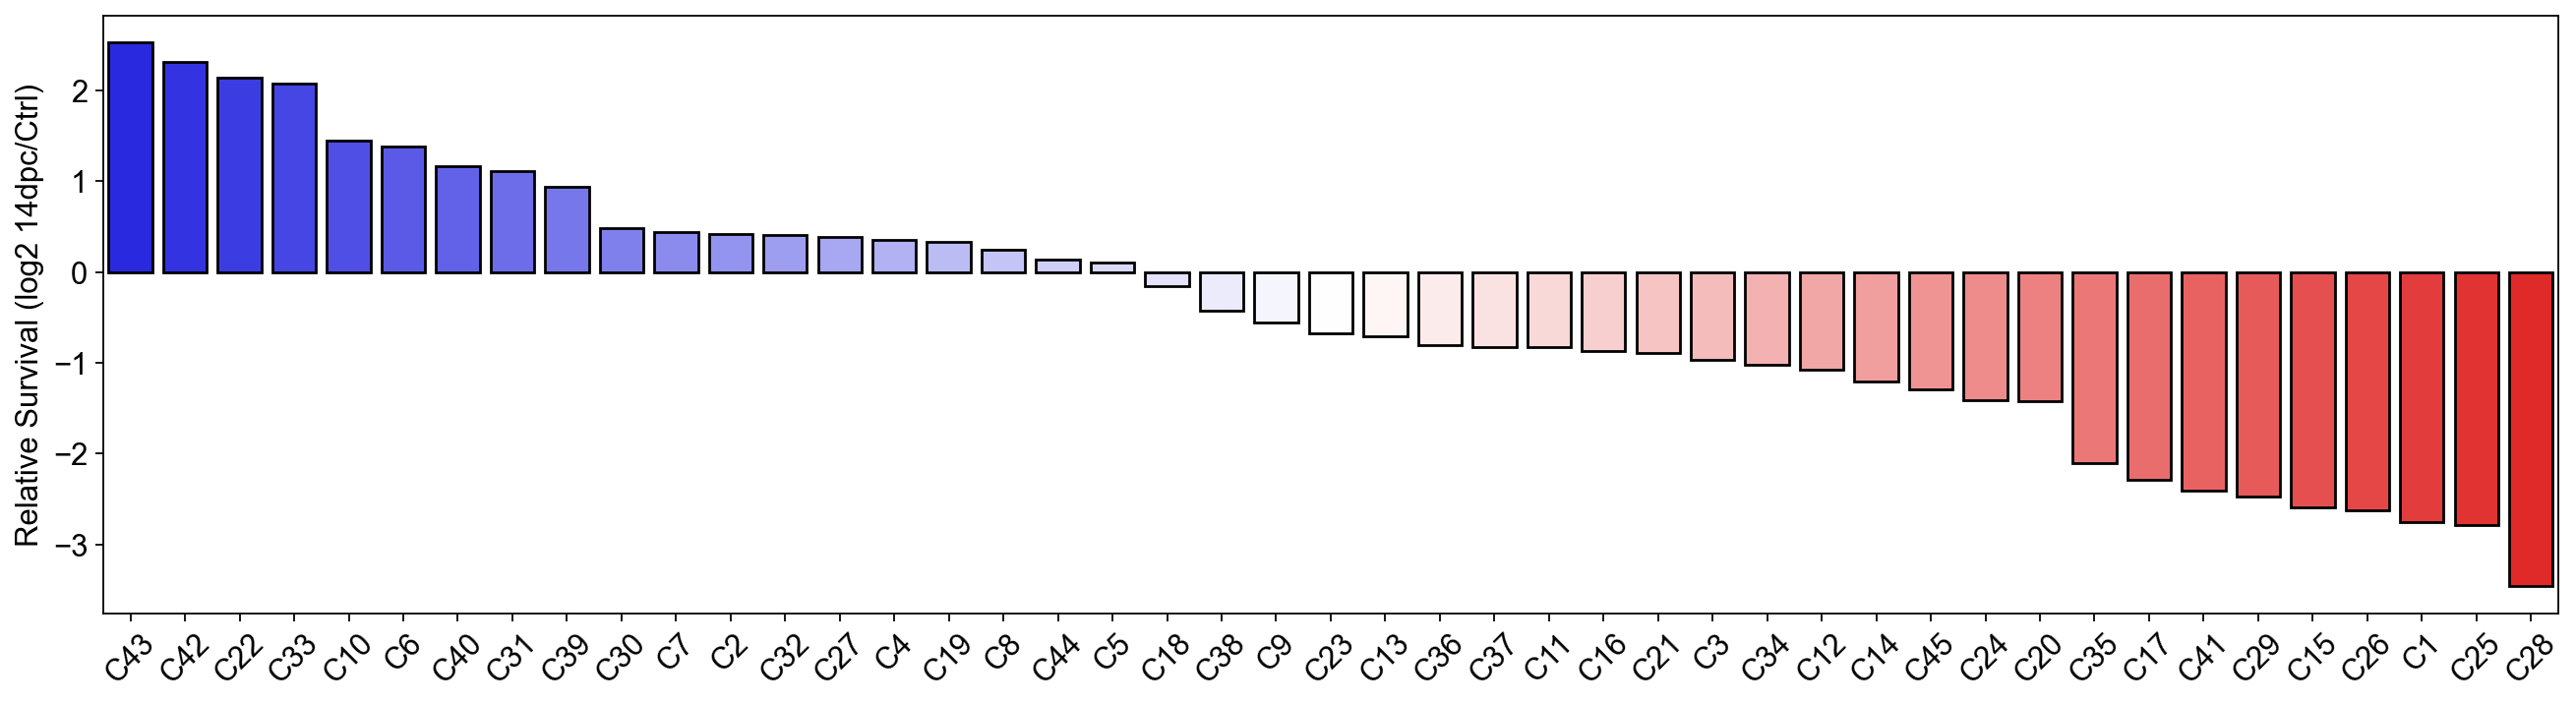

In [69]:
sc.set_figure_params(dpi_save=200, fontsize=14)
plt.rcParams["figure.figsize"] = (20,5)

#fig = plt.bar(clusts, surv_scores)
sns.barplot(surv_scores_sorted.index , surv_scores_sorted.values, palette="bwr",  edgecolor="black", linewidth=1.25)
plt.ylabel('Relative Survival (log2 14dpc/Ctrl)')
plt.xticks(rotation='45')
plt.grid(False)
plt.savefig('Figure4A.pdf')

## Figure 4B

In [70]:
ctrl = sc.read_h5ad('path/to/CtrlONC_mapped_iGB.h5ad')
twelveHr = sc.read_h5ad('path/to/twelve_hrONC_mapped_iGB.h5ad')
oneday = sc.read_h5ad('path/to/onedayONC_mapped_iGB.h5ad')
twoday = sc.read_h5ad('path/to/twodayONC_mapped_iGB.h5ad')
fourday = sc.read_h5ad('path/to/fourdayONC_mapped_iGB.h5ad')
oneweek = sc.read_h5ad('path/to/oneweekONC_mapped_iGB.h5ad')
twoweek = sc.read_h5ad('path/to/twoweekONC_mapped_iGB.h5ad')

In [71]:
onc_objs = [ctrl, twelveHr, oneday, twoday, fourday, oneweek, twoweek]

In [72]:
onc_freqs = []
for i in onc_objs:
    i = i[i.obs.Type_iGB!='Unassigned',:]
    onc_freqs.append(i.obs.Type_iGB.value_counts(normalize=True))

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [73]:
#43 
i='43'
scores43 = []
for j in onc_freqs:
    scores43.append(np.log2(j[j.index.get_loc(i)]/ctrl_freqs[ctrl_freqs.index.get_loc(i)]))

In [74]:
#28 
i='28'
scores28 = []
for j in onc_freqs:
    scores28.append(np.log2(j[j.index.get_loc(i)]/ctrl_freqs[ctrl_freqs.index.get_loc(i)]))

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


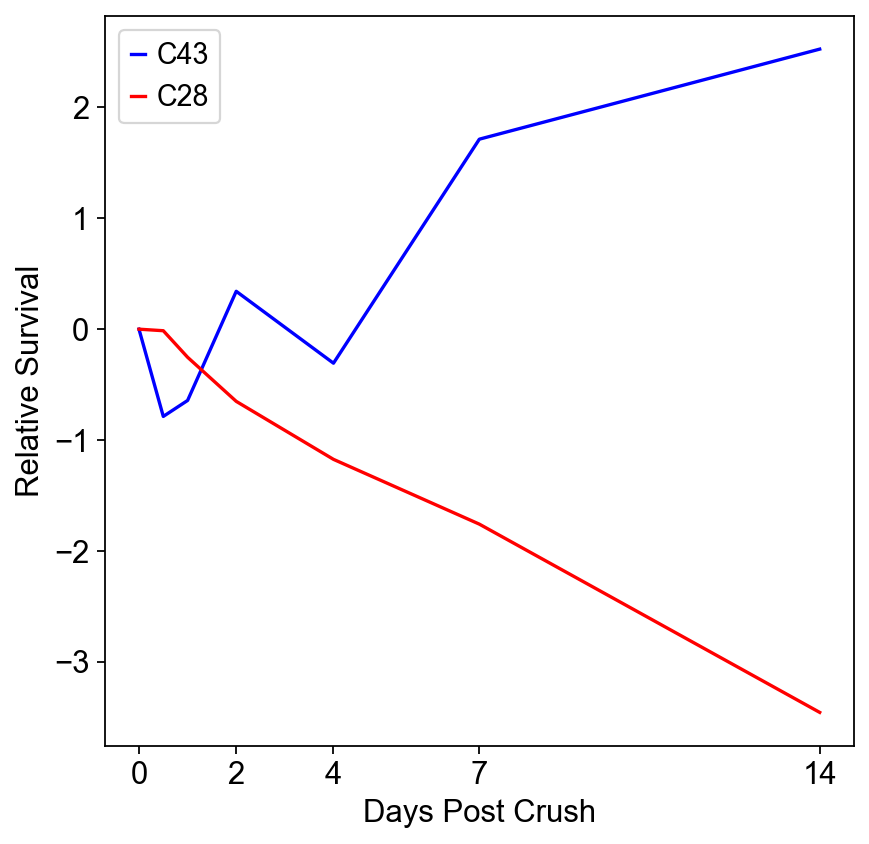

In [76]:
plt.rcParams["figure.figsize"] = (6,6)
sns.lineplot([0, 0.5, 1, 2, 4, 7, 14], scores43, label='C43', color='Blue')
sns.lineplot([0, 0.5, 1, 2, 4, 7, 14], scores28, label='C28', color='Red')

plt.xticks([0, 2, 4, 7, 14])
plt.xlabel('Days Post Crush')
plt.ylabel('Relative Survival')
plt.grid(False)
plt.legend()
plt.savefig('Figure4B.pdf')
plt.show()

## Figure 3B


Use same assignment thresholds as iGB.


In [ ]:
def atlasMapping(train_anndata, *args):
    train_genes = ClusterSpecificGenes(train_anndata, genes = list(train_anndata.var.index[train_anndata.var.highly_variable == True]), obs = 'Type_num')
    numDataSets = len(args)
    print('Running ' + str(numDataSets) + ' Mappings.')
    for i in range(0, numDataSets):
        var_genes = [j for j in train_genes if j in list(args[i].var.index)]
        validation_label_train_10, valid_predlabels_train_10, test_predlabels = xgbtrainatlas(train_anndata, test_anndata = args[i], genes = var_genes)
        mapping_assignments = []
        for k in test_predlabels:
            if k == 45:
                mapping_assignments.append('Unassigned')
            else:
                mapping_assignments.append(str(int(k)+1))
        args[i].obs['Type_Atlas'] = mapping_assignments
        numDataSets -= 1
        print('Completed ' + str(i + 1) + ' mapping! ' + str(numDataSets) + ' mappings remain.')

atlasMapping(atlas, ctrl, twelveHr, oneday, twoday, fourday, oneweek, twoweek)

ctrl.write_h5ad('path/to/CtrlONC_mapped_Atlas.h5ad')
twelveHr.write_h5ad('path/to/twelve_hrONC_mapped_Atlas.h5ad')
oneday.write_h5ad('path/to/onedayONC_mapped_Atlas.h5ad')
twoday.write_h5ad('path/to/twodayONC_mapped_Atlas.h5ad')
fourday.write_h5ad('path/to/fourdayONC_mapped_Atlas.h5ad')
oneweek.write_h5ad('path/to/oneweekONC_mapped_Atlas.h5ad')
twoweek.write_h5ad('path/to/twoweekONC_mapped_Atlas.h5ad')

In [128]:
ctrl = sc.read_h5ad('path/to/CtrlONC_mapped_Atlas.h5ad')
twelveHr = sc.read_h5ad('path/to/twelve_hrONC_mapped_Atlas.h5ad')
oneday = sc.read_h5ad('path/to/onedayONC_mapped_Atlas.h5ad')
twoday = sc.read_h5ad('/path/to/twodayONC_mapped_Atlas.h5ad')
fourday = sc.read_h5ad('path/to/fourdayONC_mapped_Atlas.h5ad')
oneweek = sc.read_h5ad('path/to/oneweekONC_mapped_Atlas.h5ad')
twoweek = sc.read_h5ad('path/to/twoweekONC_mapped_Atlas.h5ad')

In [138]:
ucf = [] #unassigned cell fraction
dir_objs = [ctrl, twelveHr, oneday, twoday, fourday, oneweek, twoweek]
mapping = []
for i in dir_objs:
    ucf.append(i.obs.Type_Atlas.value_counts(normalize=True)['Unassigned'])
    mapping.append('Direct Mapping \nto Atlas')
    ucf.append(i.uns['Unassigned info']['after step 2'][1])
    mapping.append('iGraphBoost')
    

In [139]:
df = pd.DataFrame({
    'Time point': ['0', '0', '0.5', '0.5', '1', '1', 
                   '2', '2', '4', '4', '7', '7', '14', '14'],
    'Mapping': mapping,
    'Fraction of Unassigned RGCs': ucf})

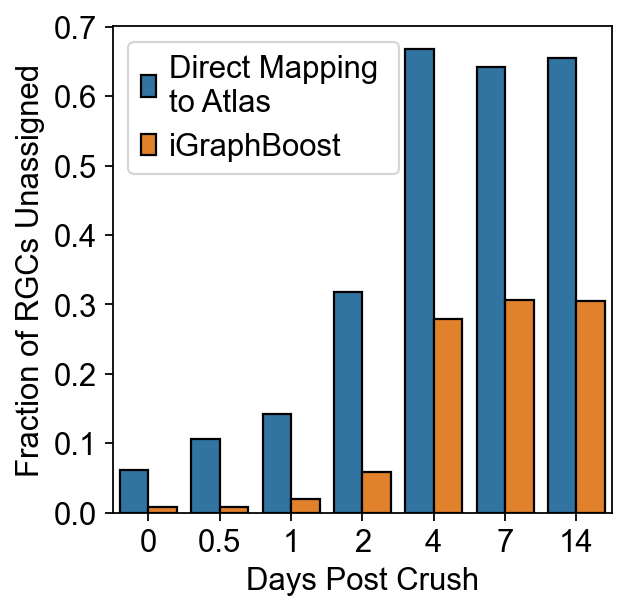

In [140]:
sns.barplot(x='Time point', y='Fraction of Unassigned RGCs', hue='Mapping', 
            data=df, edgecolor="black", linewidth=1)
plt.legend(fontsize=14)
plt.grid(False)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(ylabel = 'Fraction of RGCs Unassigned', fontsize=14)
plt.xlabel(xlabel = 'Days Post Crush', fontsize=14)
plt.savefig('Figure3B.pdf')
plt.show()

## Figure 3A

Plot percent of RGCs classified at each time point after step1 then after step2. 

In [141]:
csf = []#unclassified cells fraction
objs = [ctrl, twelveHr, oneday, twoday, fourday, oneweek, twoweek]
step = []
for i in dir_objs:
    csf.append(i.uns['Unassigned info']['after step 1'][1])
    step.append('After Step 1')
    
    csf.append(i.uns['Unassigned info']['after step 2'][1])
    step.append('After Step 2')
    

In [144]:
df = pd.DataFrame({
    'Time point': ['0', '0', '0.5', '0.5', '1', '1', 
                   '2', '2', '4', '4', '7', '7', '14', '14'],
    'Step': step,
    'Fraction of Unassigned RGCs': csf})

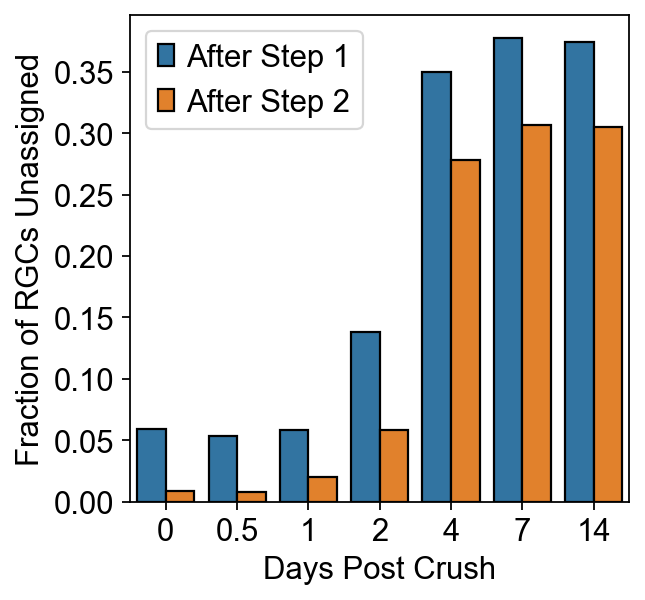

In [146]:
sns.barplot(x='Time point', y='Fraction of Unassigned RGCs', hue='Step', 
            data=df, edgecolor="black", linewidth=1)
plt.legend(fontsize=14)
plt.grid(False)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(ylabel = 'Fraction of RGCs Unassigned', fontsize=14)
plt.xlabel(xlabel = 'Days Post Crush', fontsize=14)
plt.savefig('Figure3A.pdf')
plt.show()

## Figure 3C

In [87]:
twoweek = sc.read_h5ad('path/to/twoweekONC_mapped_iGB.h5ad')

In [88]:
twoweek = twoweek[twoweek.obs.Type_iGB!='Unassigned',:]
twoweek

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 5874 × 40790
    obs: 'Type', 'Time', 'Batch', 'batch', 'Type_iGB', 'idx'
    var: 'highly_variable-0', 'mean-0', 'std-0', 'highly_variable-1', 'mean-1', 'std-1', 'highly_variable-2', 'mean-2', 'std-2'
    uns: 'Unassigned info', 'neighbors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [89]:
iGB_C = []
for i in twoweek.obs.Type_iGB.values:
    iGB_C.append('C'+str(i))
    
twoweek.obs['Type_iGB_C'] = pd.Categorical(iGB_C)   

Trying to set attribute `.obs` of view, copying.


In [90]:
twoweek_comb = diag_dotplot(twoweek)

In [95]:
cats = []
for i in range(1,46):
    cats.append('C' + str(i))

comb_vars = ['Serpine2+Amigo2+', 'Lypd1+Ntrk1-', 'Foxp2+Irx4+','Pde1a', 'Tbr1+Pcdh20+', 'Zic1', 'Tbx20+Tagln2+',
                'Prkcq+Tac1+Spp1-', 'Slc7a11+Plpp4+', 'Gpr88', 'Serpinb1b+Gm17750+', 'Mmp17', 'Lypd1+Ntrk1+', 'Cartpt+Vit+', 'Apela',
                'Cartpt+Col25a1+', 'Tbr1+Irx4+', 'Pcdh20+4833423E24Rik+', 'Penk+Prdm8+Slc24a2+',
                 'Penk+Gal+', 'Tbr1+Calca+', 'Serpine2+Cdhr1+', 'Prokr1', 'Fam19a4',
                'Slc17a7', 'Penk+Igfbp5+', 'Prkcg', 'Foxp2+Cdk15+', 'Stxbp6+Prlr+', 'Postn', 
                'Tbx20+Spp1+', 'Rhox5', 'Adcyap1+Opn4+Nmb-', 'Tpbg+Spp1-', 'Spp1+Tpbg+', 'Igfbp4+Chrm2+', 'Stxbp6+Coch+',
                'Ceacam10', 'Foxp2+Anxa3+', 'Neurod2+S100b+',  'Nmb', 'Spp1+Kit+', 'Spp1+Fes+',
                'Spp1+Il1rapl2+', 'Bhlhe22+Fxyd6+', ]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


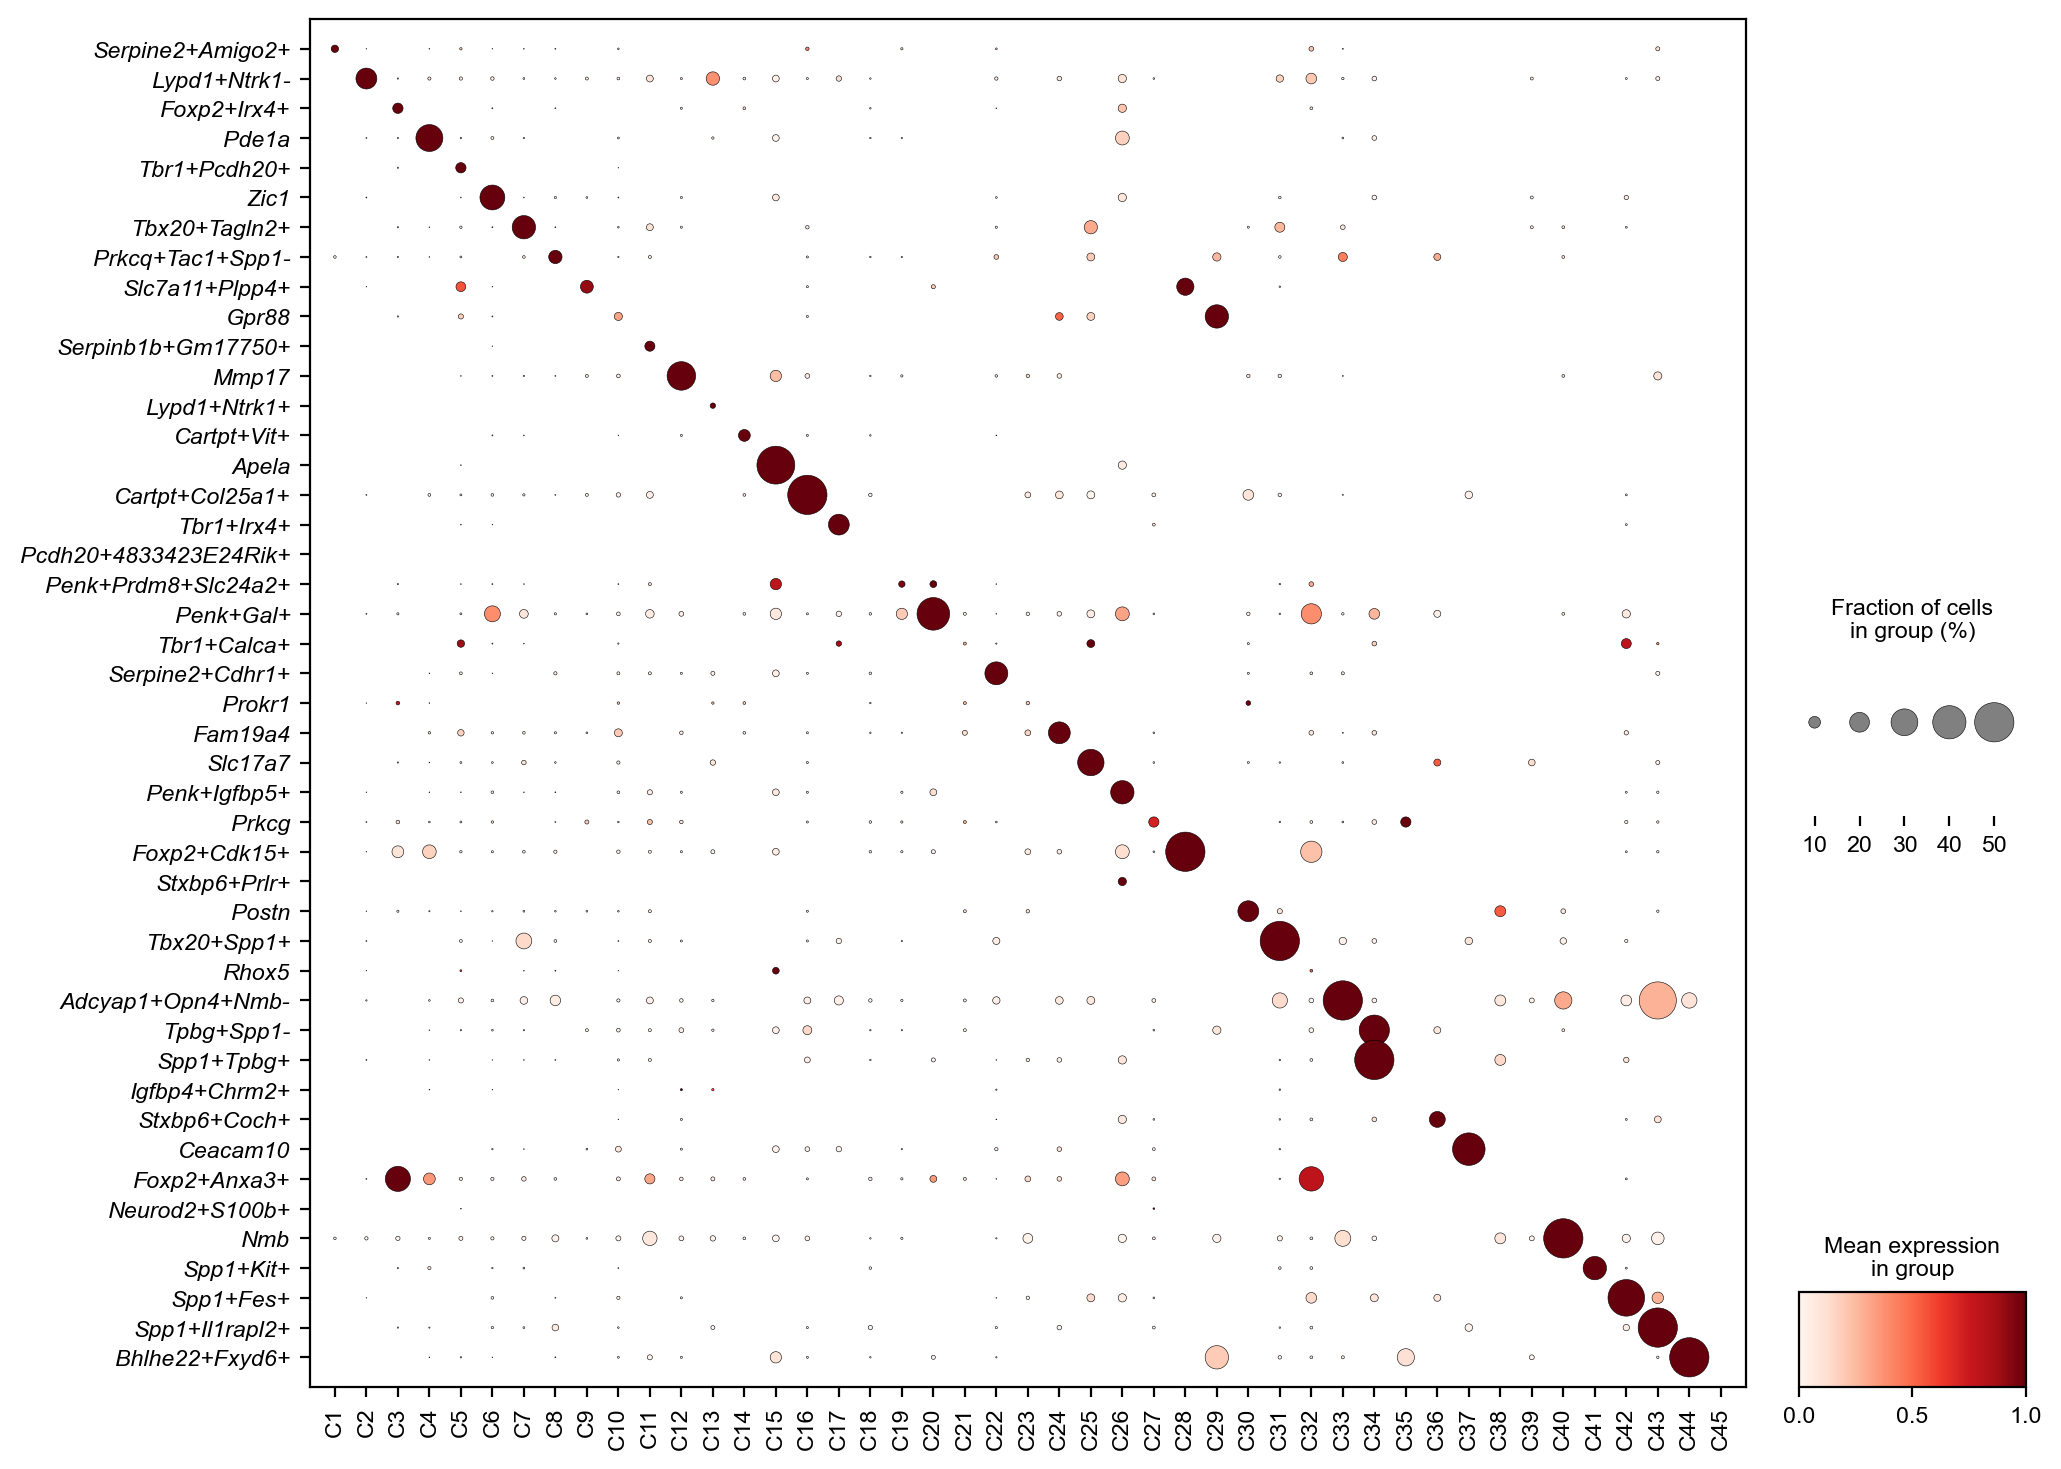

In [97]:
'''
sc.set_figure_params(dpi=200, fontsize=10)
threeC = sc.pl.dotplot(twoweek_comb, var_names=twoweek_comb.var_names, groupby='Type_iGB_C', 
                  standard_scale='var', swap_axes=True, dot_min=0, dot_max=0.6, 
              figsize=(11,9), return_fig=True).legend(width=2)

threeC.savefig('Figure3C.pdf')
'''

sc.set_figure_params(dpi=100, dpi_save = 200, fontsize=10)


fig, axs = plt.subplots(figsize=(11,9))

a = sc.pl.dotplot(twoweek_comb, var_names=comb_vars, groupby='Type_iGB_C', 
                  standard_scale='var', swap_axes=True, dot_min=0, dot_max=0.5, 
              figsize=(11,9),show=False, ax=axs, categories_order=cats)
a['mainplot_ax'].set_yticklabels(labels=comb_vars,fontstyle='italic')

fig.savefig('Figure3C.pdf')

## Figure 4C

In [98]:
twoweekclustnames = []
for i in twoweek.obs.Type.values.categories:
    if (i=='Unassigned'): twoweekclustnames.append('Unassigned') 
    else: twoweekclustnames.append(i.split('_')[0].split('C')[1])

twoweek.obs['Type_nums'] = twoweek.obs.Type.cat.rename_categories(twoweekclustnames)

In [99]:
twoweekR_freqs = twoweek.obs.Type_nums.value_counts(normalize=True)
twoweek_freqs = twoweek.obs.Type_iGB.value_counts(normalize=True)

In [100]:
PvR = [[],[]]
for i in twoweek.obs.Type_iGB.values.categories:
    PvR[0].append(twoweek_freqs[i])
    PvR[1].append(twoweekR_freqs[i])

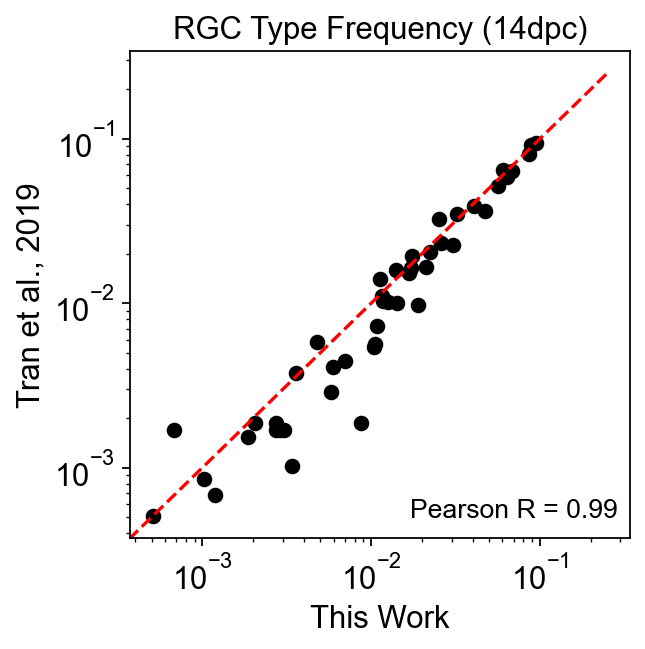

In [102]:
sc.set_figure_params(dpi_save=200, fontsize=14)
plt.scatter(PvR[0], PvR[1], color='black')
plt.plot(np.linspace(0,0.25), np.linspace(0,0.25), ls='--', color='red')
plt.title('RGC Type Frequency (14dpc)')
plt.grid(False)
plt.xlabel('This Work')
plt.ylabel('Tran et al., 2019')

plt.yscale('log')
plt.xscale('log')

plt.text(0.017,0.0005, r'Pearson R = ' + str(np.round(sp.stats.pearsonr(PvR[0], PvR[1])[0], 2)), 
         {'color': 'black', 'fontsize': 12})

plt.savefig('Figure4C.pdf')
plt.show()

# Resilience and susceptibility DE

do DE b/w res and susc clusters at 0dpc
Ensure equivalence of cluster size before running

In [24]:
ctrl = sc.read_h5ad('path/to/CtrlONC_mapped_iGB.h5ad')

Remove intermediate cells

In [25]:
#remove intermediate types
strength = []
res = list(surv_scores_sorted.index[0:8]) #resilient types
sus = list(surv_scores_sorted[-15:].index) #susceptible types

for i in range(ctrl.shape[0]):
    if ('C' + ctrl.obs.Type_iGB[i] in res): strength.append('Resilient')
    
    elif('C' + ctrl.obs.Type_iGB[i] in sus): strength.append('Susceptible')
        
    else: strength.append('Intermediate')

In [26]:
ctrl.obs['Strength'] = pd.Categorical(strength)

In [27]:
ctrl = ctrl[ctrl.obs.Strength!='Intermediate',:]

Subsample data to equalize representation of clusters

In [28]:
subsampled_objs = []
for i in ctrl.obs.Type_iGB.values.categories:
    clust = ctrl[ctrl.obs.Type_iGB==i,:]
    
    if (clust.shape[0]<100): subsampled_objs.append(subsample(clust, n_obs=100, copy=True, replace=True))
        
    else: subsampled_objs.append(subsample(clust, n_obs=100, copy=True, replace=False))

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [29]:
ctrl_sub = subsampled_objs[0].concatenate(subsampled_objs[1:])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

In [30]:
ctrl_sub

AnnData object with n_obs × n_vars = 2300 × 40790
    obs: 'Type', 'Time', 'Batch', 'Type_iGB', 'idx', 'Strength', 'batch'
    var: 'highly_variable', 'mean', 'std'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'raw'

In [119]:
resGenes = DE(ctrl_sub, obs_id='Strength', obs_id_test='Resilient', ref='Susceptible')
susGenes = DE(ctrl_sub, obs_id='Strength', obs_id_test='Susceptible', ref='Resilient')

NameError: name 'DE' is not defined

In [31]:
Strength = 'Resilient'
sc.tl.rank_genes_groups(ctrl_sub, groupby='Strength', groups=[Strength], 
                        reference='Susceptible', method='wilcoxon', n_genes=250)
#wilcGenes23vRest = list(ctrl_sub.uns['rank_genes_groups']['names'].astype([(Strength, '<U50')]).view('<U50'))  #list of genes ordered by wilc score
#if ('Malat1' in wilcGenes23vRest): del wilcGenes23vRest[wilcGenes23vRest.index('Malat1')]

wilcLF8v14 = ctrl_sub.uns['rank_genes_groups']['logfoldchanges'].astype([(Strength, '<f8')]).view('<f8') #log fold changes ordered by score

wilcGenes8v14_s = list(ctrl_sub.uns['rank_genes_groups']['names'].astype([(Strength, '<U50')]).view('<U50'))  #list of genes ordered by wilc score
wilcLF8v14_s = ctrl_sub.uns['rank_genes_groups']['logfoldchanges'].astype([(Strength, '<f8')]).view('<f8') #numpy array of logfoldchnages to be ordered lowest to highest
wilcLF8v14_s.sort() #log fold changes from lowest to highest
wilcGenes8v14 = [] #list of genes ordered by logfold change: low to high

for i in wilcLF8v14_s:
    gene_idx = np.where(wilcLF8v14 == i)[0][0]
    wilcGenes8v14.append(wilcGenes8v14_s[gene_idx])

wilcGenes8v14_correct_RES = []
for i in reversed(wilcGenes8v14):
    wilcGenes8v14_correct_RES.append(i) # #list of genes ordered by logfold change high to low

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Type' as categorical
... storing 'Type_iGB' as categorical
... storing 'Strength' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [32]:
Strength = 'Susceptible'
sc.tl.rank_genes_groups(ctrl_sub, groupby='Strength', groups=[Strength], 
                        reference='Resilient', method='wilcoxon', n_genes=250)
#wilcGenes23vRest = list(ctrl_sub.uns['rank_genes_groups']['names'].astype([(Strength, '<U50')]).view('<U50'))  #list of genes ordered by wilc score
#if ('Malat1' in wilcGenes23vRest): del wilcGenes23vRest[wilcGenes23vRest.index('Malat1')]

wilcLF8v14 = ctrl_sub.uns['rank_genes_groups']['logfoldchanges'].astype([(Strength, '<f8')]).view('<f8') #log fold changes ordered by score

wilcGenes8v14_s = list(ctrl_sub.uns['rank_genes_groups']['names'].astype([(Strength, '<U50')]).view('<U50'))  #list of genes ordered by wilc score
wilcLF8v14_s = ctrl_sub.uns['rank_genes_groups']['logfoldchanges'].astype([(Strength, '<f8')]).view('<f8') #numpy array of logfoldchnages to be ordered lowest to highest
wilcLF8v14_s.sort() #log fold changes from lowest to highest
wilcGenes8v14 = [] #list of genes ordered by logfold change: low to high

for i in wilcLF8v14_s:
    gene_idx = np.where(wilcLF8v14 == i)[0][0]
    wilcGenes8v14.append(wilcGenes8v14_s[gene_idx])

wilcGenes8v14_correct_SUS = []
for i in reversed(wilcGenes8v14):
    wilcGenes8v14_correct_SUS.append(i) # #list of genes ordered by logfold change high to low

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


In [42]:
type_igb_C = []
for i in range(ctrl.shape[0]):
    type_igb_C.append('C' + ctrl.obs.Type_iGB[i])
    
ctrl.obs['Type_iGB_C'] = pd.Categorical(type_igb_C)

Trying to set attribute `.obs` of view, copying.


## C6 vs Susceptible

In [72]:
sus_types = ctrl_sub[ctrl_sub.obs.Strength=='Susceptible',:].obs.Type_iGB.values.categories

de_types = []
for i in range((ctrl_sub.shape[0])):
    
    if (ctrl_sub.obs.Type_iGB[i] in sus_types): de_types.append('sus')
    elif (ctrl_sub.obs.Type_iGB[i] == '6'): de_types.append('C6')
    else: de_types.append('res')
    

In [75]:
ctrl_sub.obs['de_types'] = pd.Categorical(de_types)

In [76]:
DE(ctrl_sub, obs_id='de_types', obs_id_test='C6', ref ='sus')[0:10]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


['Zic1',
 'Adgrg2',
 'Ulk4',
 'Sgcz',
 'Isl2',
 'Penk',
 'Ndst4',
 'Serpinb1b',
 'Plch1',
 'Sdk2']

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


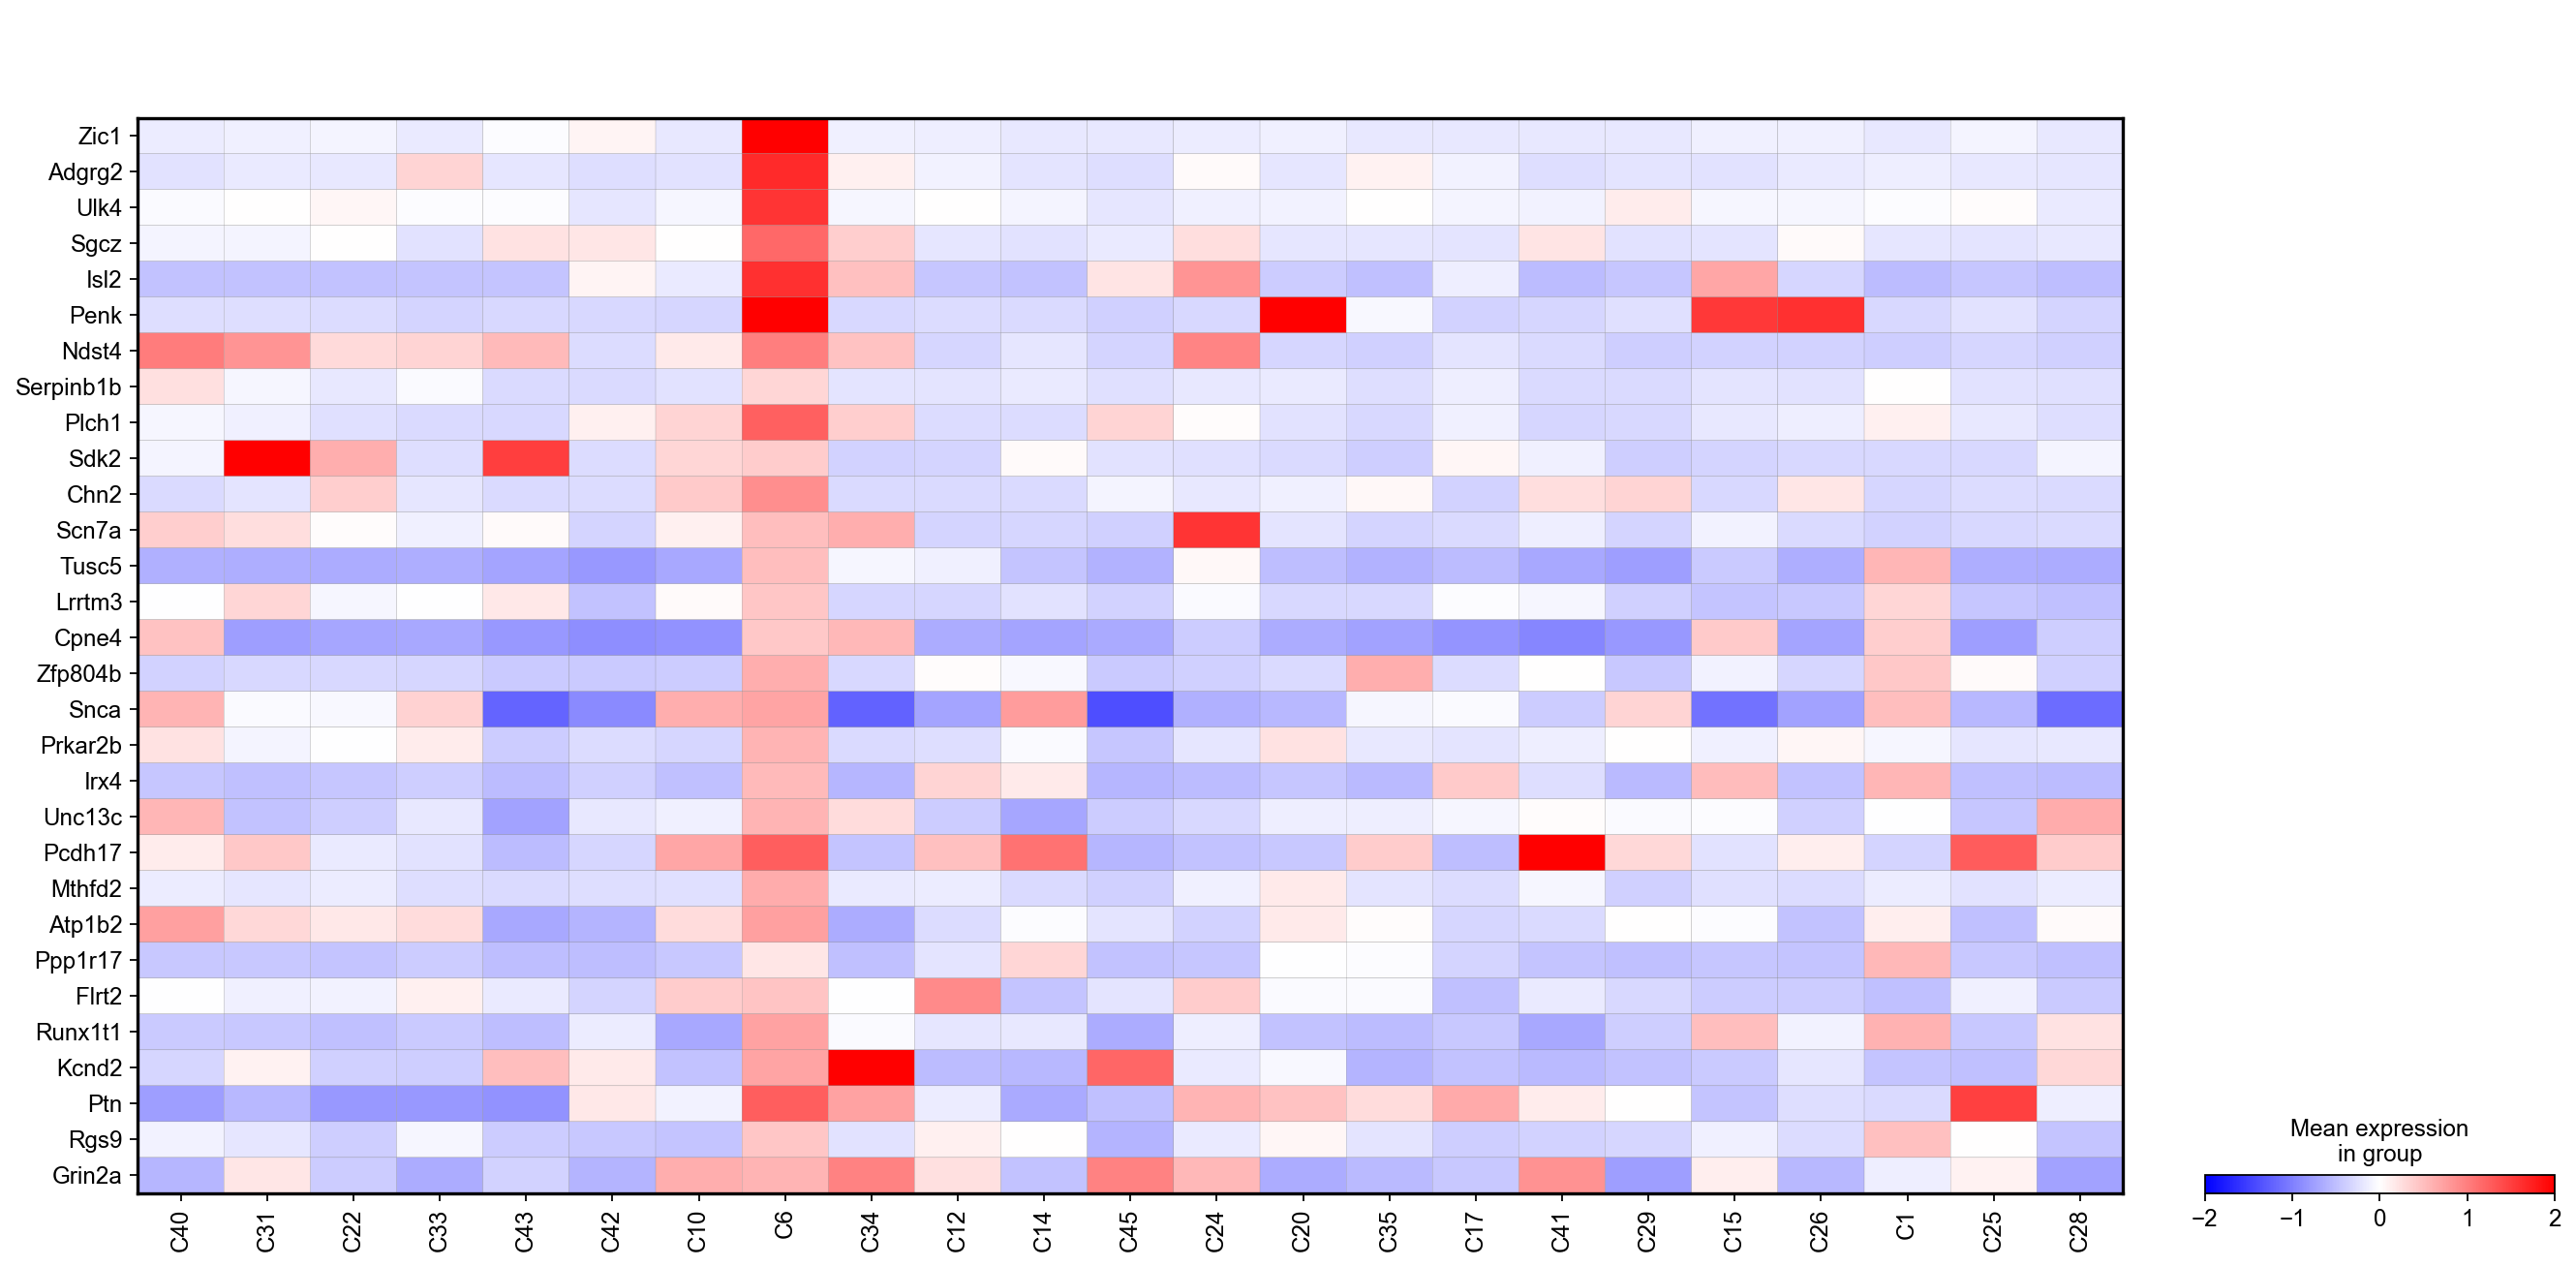

In [78]:
sc.set_figure_params(dpi_save=200, fontsize=13)
cats = ['C40', 'C31', 'C22', 'C33', 'C43', 'C42', 'C10', 'C6', 
       'C34', 'C12', 'C14', 'C45', 'C24', 'C20', 'C35', 'C17', 'C41', 'C29', 'C15', 'C26', 'C1','C25','C28']

fig, axs = plt.subplots(figsize=(20,10))

a = sc.pl.matrixplot(ctrl,DE(ctrl_sub, obs_id='de_types', obs_id_test='C6', ref ='sus')[0:30], 
                 groupby='Type_iGB_C', categories_order = cats,
              use_raw=False, cmap='bwr', vmin = -2, vmax=2,swap_axes=True,  show=False, ax=axs, )



## Figure 5A

In [124]:
ctrl.obs['Type_iGB_C'].value_counts()

C1     1012
C12     419
C10     416
C6      394
C14     324
C17     279
C15     257
C25     239
C20     224
C26     201
C24     190
C29     180
C22     173
C34     140
C31     140
C28     134
C33     116
C35     105
C40      60
C42      46
C41      43
C43      29
C45      15
Name: Type_iGB_C, dtype: int64

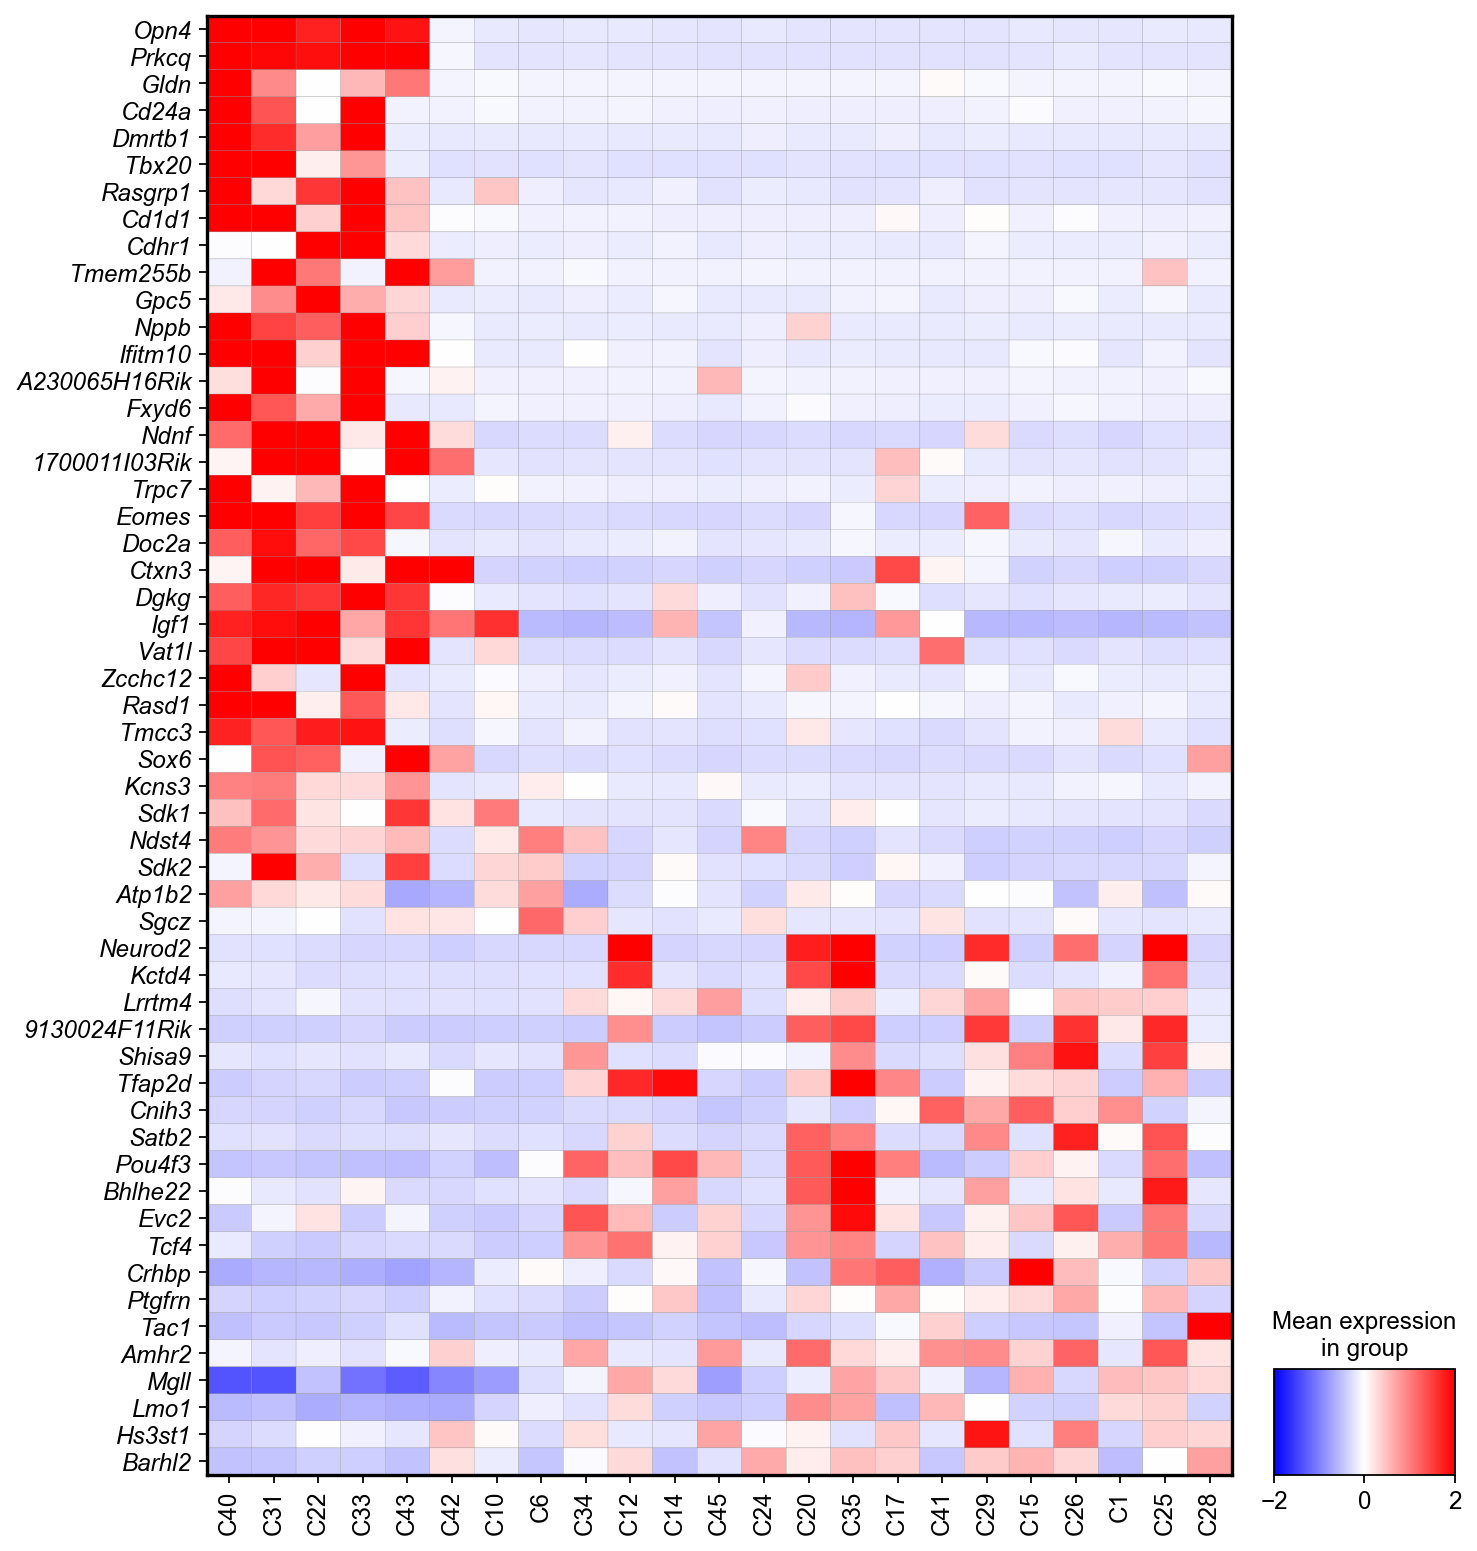

In [83]:
sc.set_figure_params(dpi_save=200, fontsize=13)
cats = ['C40', 'C31', 'C22', 'C33', 'C43', 'C42', 'C10', 'C6', 
       'C34', 'C12', 'C14', 'C45', 'C24', 'C20', 'C35', 'C17', 'C41', 'C29', 'C15', 'C26', 'C1','C25','C28']

fig, axs = plt.subplots(figsize=(10,12))

a = sc.pl.matrixplot(ctrl, wilcGenes8v14_correct_RES[0:30] + ['Ndst4', 'Sdk2', 'Atp1b2', 'Sgcz'] + wilcGenes8v14_correct_SUS[0:20]  , 
                 groupby='Type_iGB_C', categories_order = cats,
              use_raw=False, cmap='bwr', vmin = -2, vmax=2,swap_axes=True, 
                 figsize=(10,12), show=False, ax=axs, )

a['mainplot_ax'].set_yticklabels(labels= wilcGenes8v14_correct_RES[0:30]+ ['Ndst4', 'Sdk2', 'Atp1b2', 'Sgcz'] + wilcGenes8v14_correct_SUS[0:20],
                                 fontstyle='italic')

fig.savefig('Figure5A.pdf')

## Figure 5B

In [196]:
oneweek = sc.read_h5ad('path/to/oneweekONC_mapped_iGB.h5ad')

In [197]:
oneweek = oneweek[oneweek.obs.Type_iGB!='Unassigned',:]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [198]:
strength = []
for i in range(oneweek.shape[0]):
    if ('C' + oneweek.obs.Type_iGB[i] in res): strength.append('Resilient')
    
    elif('C' + oneweek.obs.Type_iGB[i] in sus): strength.append('Susceptible')
        
    else: strength.append('Intermediate')

oneweek.obs['Strength'] = pd.Categorical(strength)
oneweek = oneweek[oneweek.obs.Strength!='Intermediate',:]

Trying to set attribute `.obs` of view, copying.


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

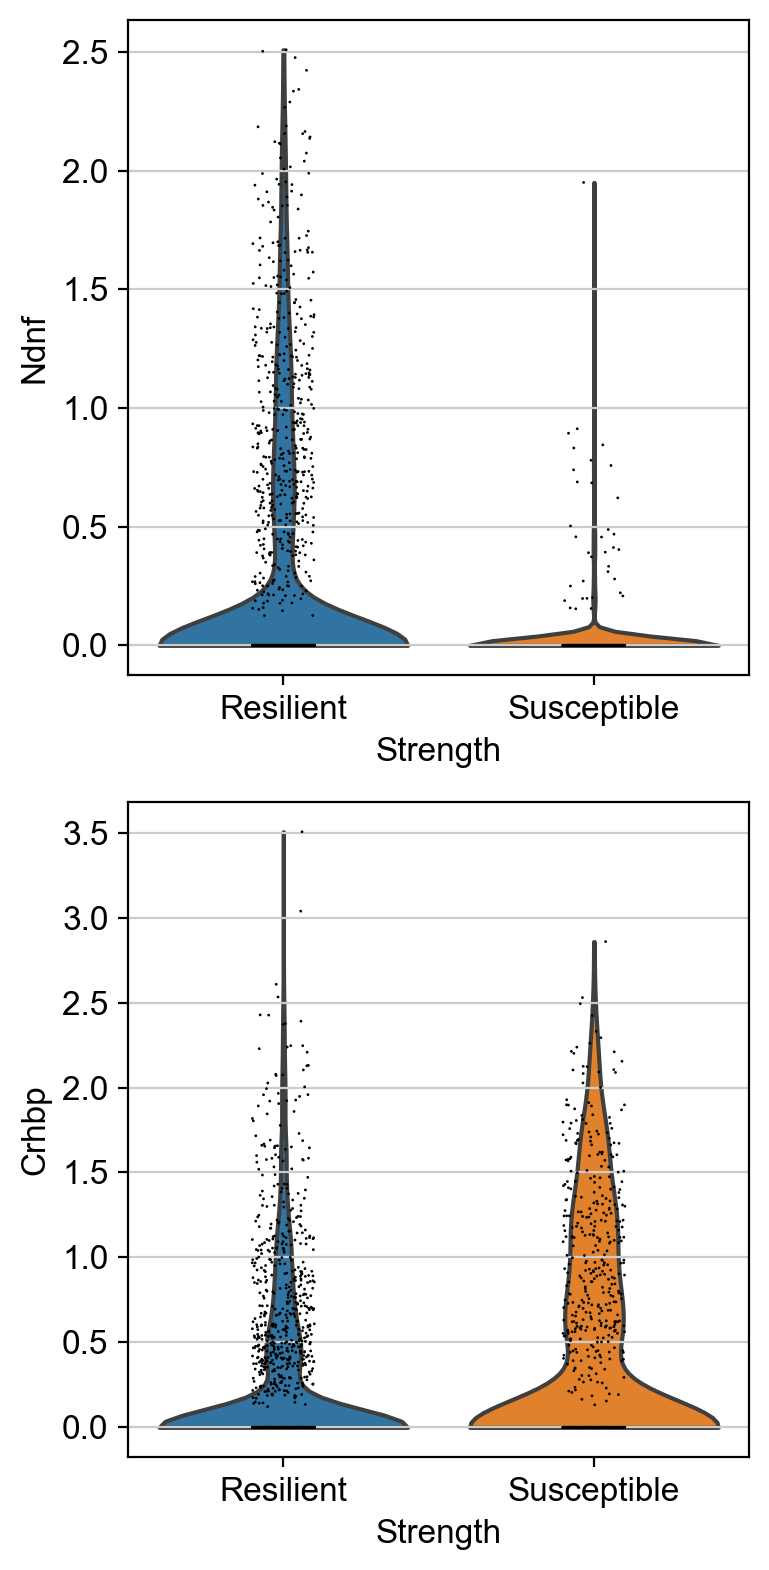

In [204]:
fig, axs = plt.subplots(2,1, figsize=(4,8))
sc.pl.violin(oneweek, 'Ndnf', groupby='Strength', show=False, ax=axs[0])
sc.pl.violin(oneweek, 'Crhbp', groupby='Strength', show=False, ax=axs[1])
plt.tight_layout()

fig.savefig('Figure5B_oneweek.pdf')

## Ndnf and Crhbp in 14d

In [647]:
strength = []
for i in range(twoweek.shape[0]):
    if ('C' + twoweek.obs.Type_iGB[i] in res): strength.append('Resilient')
    
    elif('C' + twoweek.obs.Type_iGB[i] in sus): strength.append('Susceptible')
        
    else: strength.append('Intermediate')

twoweek.obs['Strength'] = pd.Categorical(strength)
twoweek = twoweek[twoweek.obs.Strength!='Intermediate',:]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Trying to set attribute `.uns` of view, copying.
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


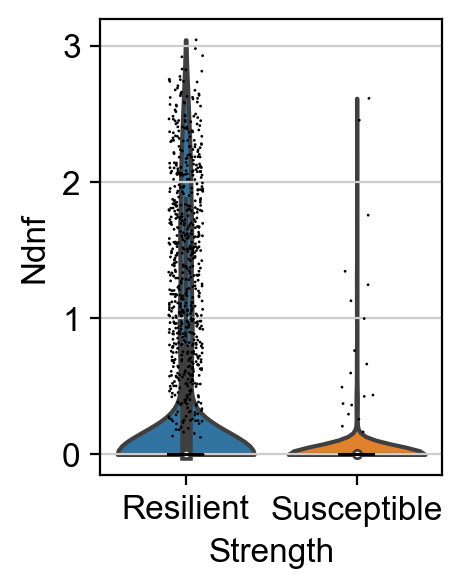

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


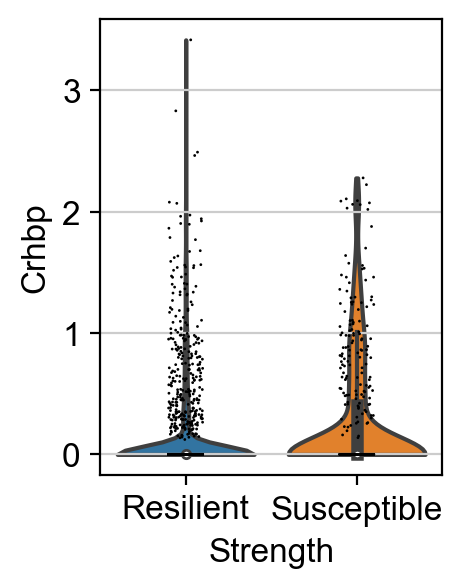

In [649]:
sc.pl.violin(twoweek, 'Ndnf', groupby='Strength', inner='box')
sc.pl.violin(twoweek, 'Crhbp', groupby='Strength', inner='box')

# Figure 5D

In [21]:
ctrl = sc.read_h5ad('path/to/CtrlONC_mapped_iGB.h5ad')
twelveHr = sc.read_h5ad('path/to/twelve_hrONC_mapped_iGB.h5ad')
oneday = sc.read_h5ad('path/to/onedayONC_mapped_iGB.h5ad')
twoday = sc.read_h5ad('path/to/twodayONC_mapped_iGB.h5ad')
fourday = sc.read_h5ad('path/to/fourdayONC_mapped_iGB.h5ad')
oneweek = sc.read_h5ad('path/to/oneweekONC_mapped_iGB.h5ad')
twoweek = sc.read_h5ad('path/to/twoweekONC_mapped_iGB.h5ad')

In [22]:
onc_objs = ctrl.concatenate(twelveHr, oneday, twoday, fourday, oneweek, twoweek)

In [23]:
onc_objs = onc_objs[onc_objs.obs.Type_iGB!='Unassigned',:]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [24]:
pd.Categorical(onc_objs.obs.Time)

['Ctrl', 'Ctrl', 'Ctrl', 'Ctrl', 'Ctrl', ..., '2w', '2w', '2w', '2w', '2w']
Length: 67360
Categories (7, object): ['12h', '1d', '1w', '2d', '2w', '4d', 'Ctrl']

In [25]:
onc_objs.obs.Type_iGB.values.categories

Index(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2',
       '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30',
       '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41',
       '42', '43', '44', '45', '5', '6', '7', '8', '9'],
      dtype='object')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/a

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/a

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. Fr

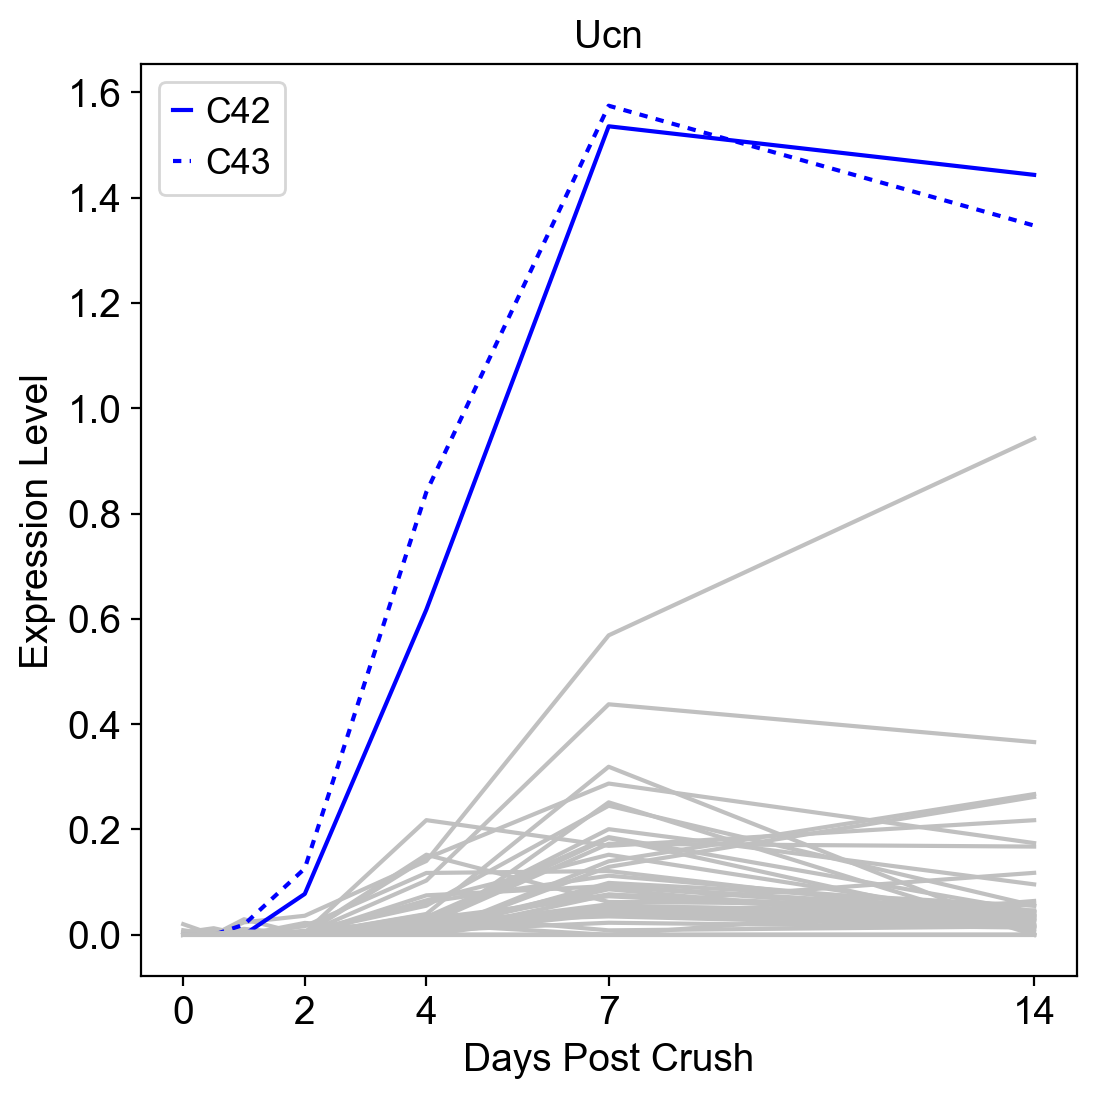

In [26]:
plt.rcParams["figure.figsize"] = (6,6)


ucn_idx = onc_objs.var.index.get_loc('Ucn')
times = ['Ctrl', '12h', '1d',  '2d', '4d', '1w', '2w']

for j in onc_objs.obs.Type_iGB.values.categories:
    clust = onc_objs[onc_objs.obs.Type_iGB==j,:]
    clust_exp = []
    for i in times:
        clust_exp.append(np.mean(clust[clust.obs.Time==i,:].raw.X[:,ucn_idx]))
        
    if j in (['43']): sns.lineplot([0, 0.5, 1, 2, 4, 7, 14], clust_exp, 
                                   label='C'+j, color='Blue', style=True, dashes=[(2,2)], legend=False)
    elif j in (['42']): sns.lineplot([0, 0.5, 1, 2, 4, 7, 14], clust_exp, label='C'+j, color='Blue')
 
    else: sns.lineplot([0, 0.5, 1, 2, 4, 7, 14], clust_exp, color='Silver')

plt.xticks([0, 2, 4, 7, 14])
plt.xlabel('Days Post Crush')
plt.ylabel('Expression Level')
plt.title('Ucn')
plt.grid(False)
plt.legend()

plt.savefig('Figure5D.pdf')
plt.show()
